# Compute and Analyze Classifier Metrics

The snakemake pipeline output the probability of 0 / 1 for each cell for each classifier. Here, we compute and save many common metrics from these probabilities. Here we analyze the classification results of each allele.

In [1]:
# imports
import os
import glob
import operator
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from functools import reduce
import sys
sys.path.append("../..")
from img_utils import *

letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}
channel_list = list(channel_dict_rev.values())[:-3]

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
AUROC_THRESHOLDS = [0.95, 0.99]

## 1. Loading data

### Read in platemap metadata and imaging well QC info

In [2]:
# allele_meta_df = pl.DataFrame()
# allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

# for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
#     for batch_id in bio_rep_batches:
#         allele_meta_df_batch = pl.DataFrame()
#         platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
#         for platemap in platemaps:
#             platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
#             allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
#                                         platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
#                                         how="diagonal_relaxed").sort("plate_map_name")
#             allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
#             # display(allele_meta_df.head())
#         allele_meta_df = pl.concat([
#             allele_meta_df,
#             allele_meta_df_batch
#         ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
#     allele_meta_df_dict[bio_rep] = allele_meta_df_batch

#     img_well_qc_sum = pl.read_csv(f"{IMGS_QC_METRICS_DIR}/{bio_rep}/plate-well-level_img_qc_sum.csv")
#     img_well_qc_sum = img_well_qc_sum.with_columns(
#         pl.col("channel").replace("DAPI", "DNA").alias("channel")
#     )
#     img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
#     img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
#         pl.col("is_bg").max().alias("is_bg"),
#         pl.col("s2n_ratio").mean().alias("s2n_ratio")
#     ).with_columns(pl.lit("Morph").alias("channel"))
#     img_well_qc_sum = pl.concat([
#         img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
#         img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
#     ], how="vertical_relaxed")
#     img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [3]:
allele_meta_df = pl.read_csv(IMG_METADATA_FILE, infer_schema_length=10000)
img_well_qc_sum_df = pl.read_csv(IMG_QC_SUM_DF_FILE, infer_schema_length=10000)

with open(IMG_METADATA_DICT_FILE, "rb") as f:
    allele_meta_df_dict = pickle.load(f)

with open(IMG_QC_SUM_DICT_FILE, "rb") as f:
    img_well_qc_sum_dict = pickle.load(f)

### Read in the metric per each XGB Classifer

In [4]:
class_info_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv"
class_info_gfp_adj_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_gfp_adj.csv"

In [5]:
# for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
#     for batch_id in bio_rep_batches:
#         class_res_df = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id))
#         class_res_df = class_res_df.with_columns(
#             pl.when((pl.col("well_0").str.contains(r"(?:01|P|A|24)"))|(pl.col("well_1").str.contains(r"(?:01|P|A|24)")))
#             .then(pl.lit(True))
#             .otherwise(pl.lit(False))
#             .alias("Well_On_Edge")
#         )

#         # display(class_res_df)
#         for channel in channel_list:
#             img_well_qc_sum = img_well_qc_sum_dict[bio_rep]
#             class_res_df_channel = class_res_df.filter(pl.col("Metadata_Feature_Type")==channel)
#             class_res_df_channel = class_res_df_channel.join(
#                 img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
#                 left_on=["Plate","well_0"],""
#                 right_on=["plate","well"]
#             ).rename({"is_bg": "well_0_is_bg"})
#             class_res_df_channel = class_res_df_channel.join(
#                 img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
#                 left_on=["Plate","well_1"],
#                 right_on=["plate","well"]
#             ).rename({"is_bg": "well_1_is_bg"})
            
#             plate_maps = sorted(set(["_".join(pm.split("_")[:-1]) for pm in class_res_df_channel["Plate"].unique()]))
#             for pm in plate_maps:
#                 class_res_ch_pm = class_res_df_channel.filter(pl.col("Plate").str.contains(pm))
#                 plates = sorted(class_res_ch_pm["Plate"].unique().to_list())
#                 # fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#                 for plate in plates:
#                     plate_info = class_res_ch_pm.filter(pl.col("Plate")==plate)
    
#                     ## plot the ctrls alleles first
#                     plate_info_ctrl = plate_info.filter(pl.col("Metadata_Control"))
#                     ctrls_wells = pl.concat([plate_info_ctrl["well_0"], plate_info_ctrl["well_1"]]).unique()
#                     agg_group_by_well_0 = plate_info_ctrl.group_by("well_0","allele_0").agg([
#                         pl.col("AUROC").mean().alias("AUROC_Mean"),
#                         pl.col("well_0_is_bg").max().alias("is_bg")
#                     ]).rename(
#                         {"well_0": "well", "allele_0": "allele"}
#                     )#.with_columns(pl.col("Well_On_Edge").cast(pl.Boolean).alias("Well_On_Edge"))
#                     agg_group_by_well_1 = plate_info_ctrl.filter(
#                         (pl.col("well_1").is_in(ctrls_wells))&\
#                         (~pl.col("well_1").is_in(agg_group_by_well_0["well"]))
#                     ).group_by("well_1","allele_1").agg([
#                         pl.col("AUROC").mean().alias("AUROC_Mean"),
#                         pl.col("well_1_is_bg").max().alias("is_bg")
#                     ]).rename(
#                         {"well_1": "well", "allele_1": "allele"}
#                     )
#                     agg_group_by_well = pl.concat(
#                         [
#                             agg_group_by_well_0.select(pl.col("well","AUROC_Mean","allele","is_bg")),
#                             agg_group_by_well_1.select(pl.col("well","AUROC_Mean","allele","is_bg"))
#                         ]
#                     )
#                     ## plot the auroc per each plate for a platemap
#                 #     plot_platemap(
#                 #         agg_group_by_well,
#                 #         plate+f"_{channel}",
#                 #         well_pos_col="well",
#                 #         # this is the column to color by (categorical or continuous)
#                 #         value_col="AUROC_Mean",
#                 #         # these columns will be concatenated into the annotation text
#                 #         label_cols=("allele","AUROC_Mean"),
#                 #         ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 #         value_type="continuous",   # or "continuous"
#                 #         continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 #         categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
#                 #         grid_square="is_bg"
#                 #     )
#                 # fig.subplots_adjust(wspace=-.55, hspace=.05)
#                 # plt.tight_layout()

## 2. Classification metrics

### 2.1 Analyze the metrics per each classifier

Each tested allele should have 2 (protein mislocalization & morphology) * 4 (technical replicates) = 8 classifiers per each batch.

In [25]:
metric_df_dict = {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        metrics_df = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id)).with_columns(
            pl.col("Metadata_Feature_Type").alias("Classifier_type")
        )
        metrics_gfp_adj_df = pl.read_csv(class_info_gfp_adj_dir.format(CLASS_ANALYSES_DIR, batch_id))
        metrics_gfp_adj_df = metrics_gfp_adj_df.with_columns(
            pl.lit("GFP_ADJ").alias("Classifier_type")
        )
        metrics_df = pl.concat([metrics_df, metrics_gfp_adj_df])
        batch_id = f"B{batch_id.split('Batch_')[-1]}"
        
        # display(metrics_df)
        print(f"====================================={batch_id} metrics=====================================")
        metrics_df = metrics_df.with_columns(
            pl.when(pl.col("Metadata_Control"))
            .then(pl.lit("1_Ctrl"))
            .otherwise(pl.lit("2_VAR-WT"))
            .alias("Node_Type"),
            # Extract the substring that:
            #  1. Has a digit (\d) immediately before it (anchors the match at a number)
            #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
            #  3. Stops right before the literal 'T'
            pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
            pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
        )
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg")),
            left_on=["Plate", "well_0", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({"is_bg": "well_0_is_bg"})
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg")),
            left_on=["Plate", "well_1", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({"is_bg": "well_1_is_bg"})
    
        """
            Calculating controls
        """
        metrics_ctrl_df = metrics_df.filter(
            (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
        )
        
        # Filter based on class imbalance
        metrics_ctrl = (
            metrics_ctrl_df
            .select(["Classifier_type", "Batch", "AUROC"])
            .group_by(["Classifier_type", "Batch"])
            .agg([
                pl.col("AUROC").mean().alias("AUROC_mean"),
                pl.col("AUROC").std().alias("AUROC_std")
            ]+[
                pl.col("AUROC").quantile(auroc_thres).alias(f"AUROC_thresh_{auroc_thres*100:.0f}") for auroc_thres in AUROC_THRESHOLDS
            ])
        )
        
        for feat in FEAT_SETS:
            print(f"Total number of control classifiers {feat}:", metrics_ctrl_df.filter((pl.col("Classifier_type") == feat)).shape[0])
        
        print("==========================================================================")
        metric_df_dict[f"{batch_id}_met"] = metrics_df
        # Merge with metrics_df and decide whether it passed the threshold
        metrics_df_thres = metrics_df.join(metrics_ctrl, 
                                           left_on=["Metadata_Feature_Type", "Batch"],
                                           right_on=["Classifier_type", "Batch"])
        # print(metrics_df_thres.head())
        metrics_df_thres = metrics_df_thres.with_columns(
            ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
        )
        
        ## Must be at least min_class_num classifiers per batch
        ## Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (~pl.col("Metadata_Control")) & \
                (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        print(f"Total number of unique classifiers for GFP:", classifier_count.shape[0])
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")
    
        # Must be at least min_class_num classifiers per batch
        # Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
                & (~pl.col("Metadata_Control"))
                & (pl.col("Classifier_type") == "GFP")
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        # display(classifier_count)
        # break
        print(f"After filtering out classifiers with training imbalance > {TRN_IMBAL_THRES}:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")
    
        classifier_count = classifier_count.filter(
            (pl.col(batch_id) >= MIN_CLASS_NUM)
        )
        print("After filtering out alleles with available number of classifiers < 2:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    
        # filter based on this
        keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
        metrics_df_thres = metrics_df_thres.filter(
            ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
        )
    
        # Filter by imbalance and calculate mean AUROC for each batch
        metrics_wtvar = (
            (
                metrics_df_thres.filter(
                    (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                    (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
                )
            )
            .select([
                "AUROC",
                "AUROC_zscore",
                "Classifier_type",
                "Batch",
                "allele_0",
                "trainsize_0",
                "testsize_0",
                "trainsize_1",
                "testsize_1",
                "Allele_set",
                "Training_imbalance",
            ]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS])
            .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
            .agg([
                pl.all()
                .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
                .mean()
                .name.suffix("_mean")
            ])
        )
        metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres
        metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

        os.makedirs(f"{CLASS_INTERIM_DIR}/{bio_rep}/{batch_id}", exist_ok=True)
        metrics_wtvar.write_csv(f"{CLASS_INTERIM_DIR}/{bio_rep}/{batch_id}/metrics_summary.csv")

=====================================B7 metrics=====================================
Total number of control classifiers GFP: 374
Total number of control classifiers DNA: 376
Total number of control classifiers Mito: 376
Total number of control classifiers AGP: 376
Total number of control classifiers Morph: 376
Total number of unique classifiers for GFP: 405
Total number of unique variant alleles: 405
Total number of unique WT genes: 80
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (402, 4)
Total number of unique variant alleles: 402
Total number of unique WT genes: 78
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (401, 4)
Total number of unique variant alleles: 401
Total number of unique WT genes: 78
=====================================B8 metrics=====================================
Total number of control classifiers GFP: 236
Total number of control classifiers DNA: 228
Tot

## 3. Plotting Metrics

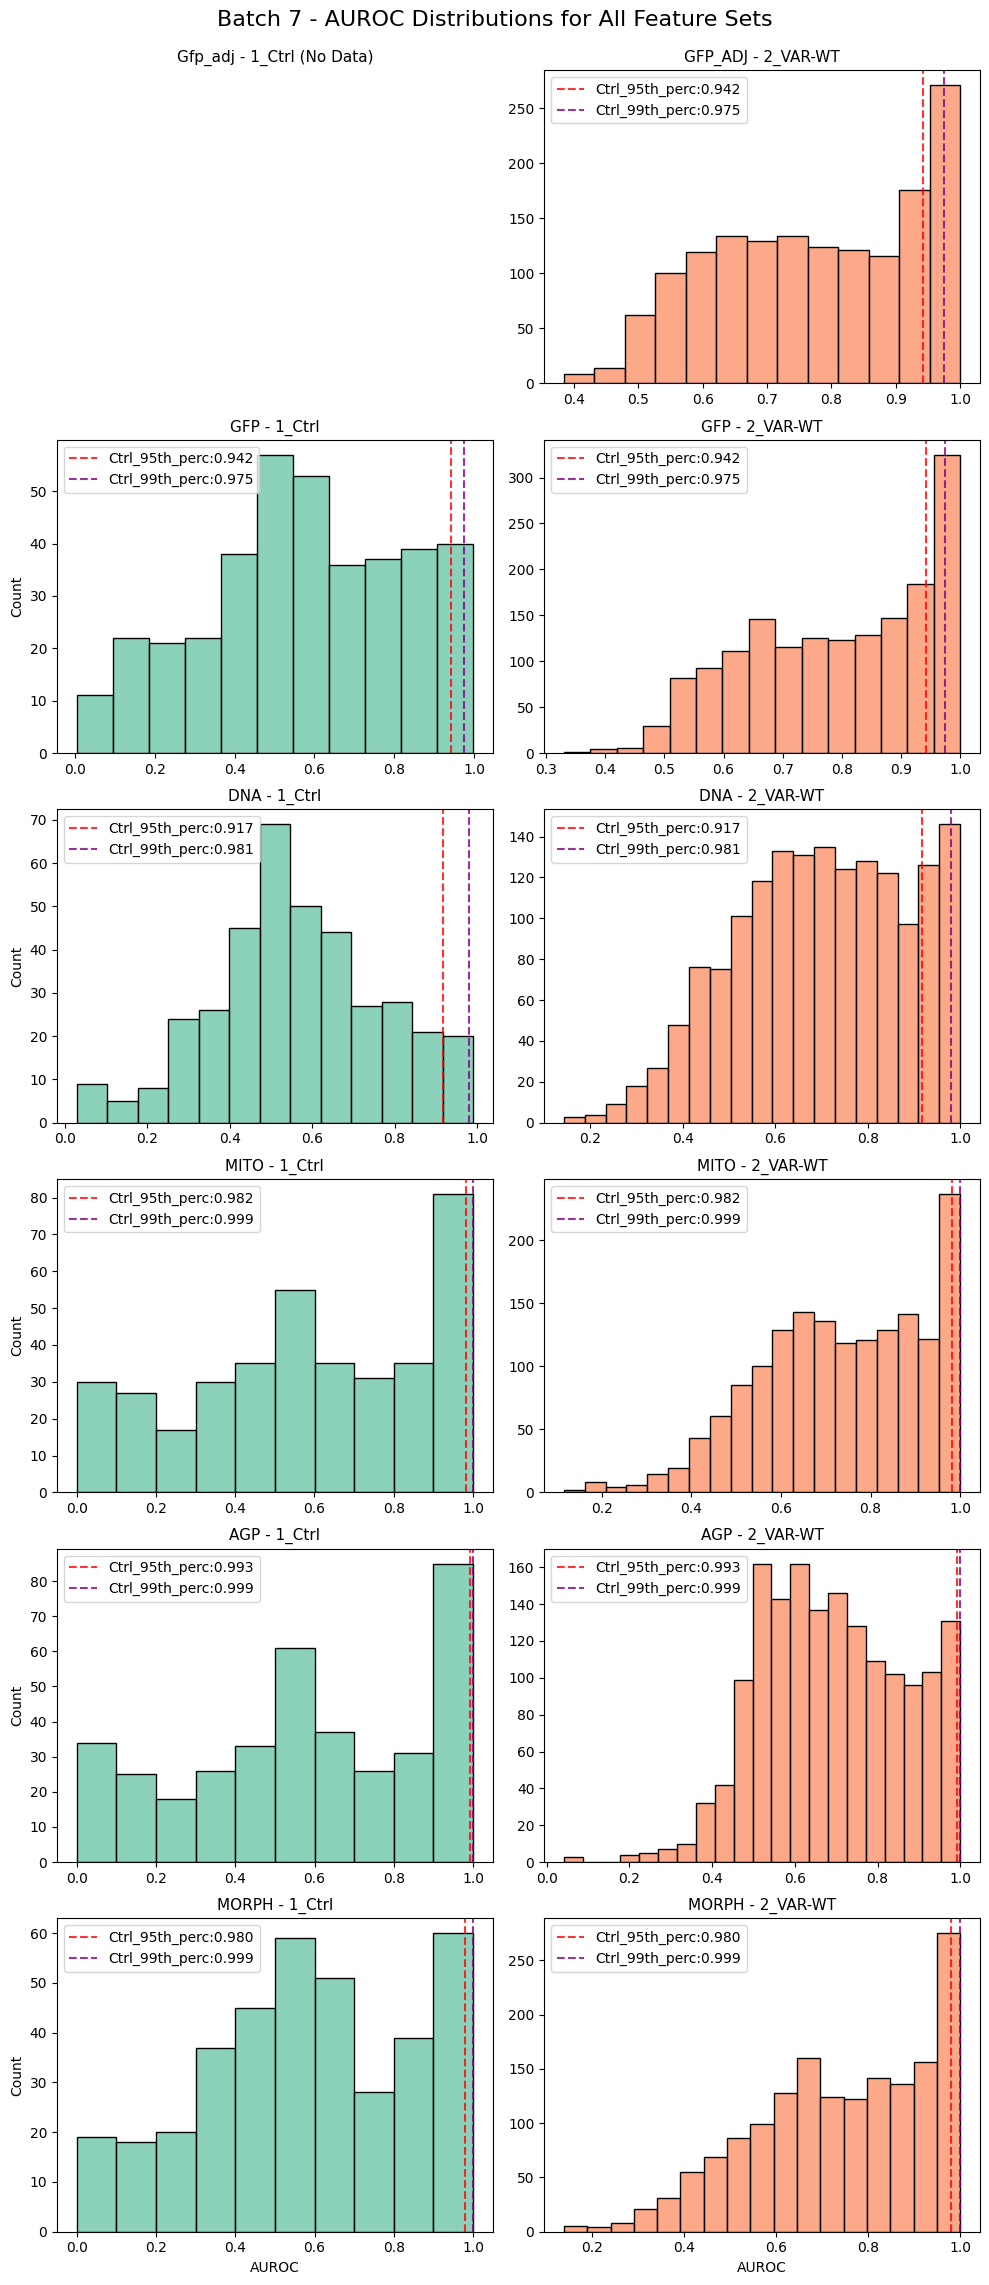

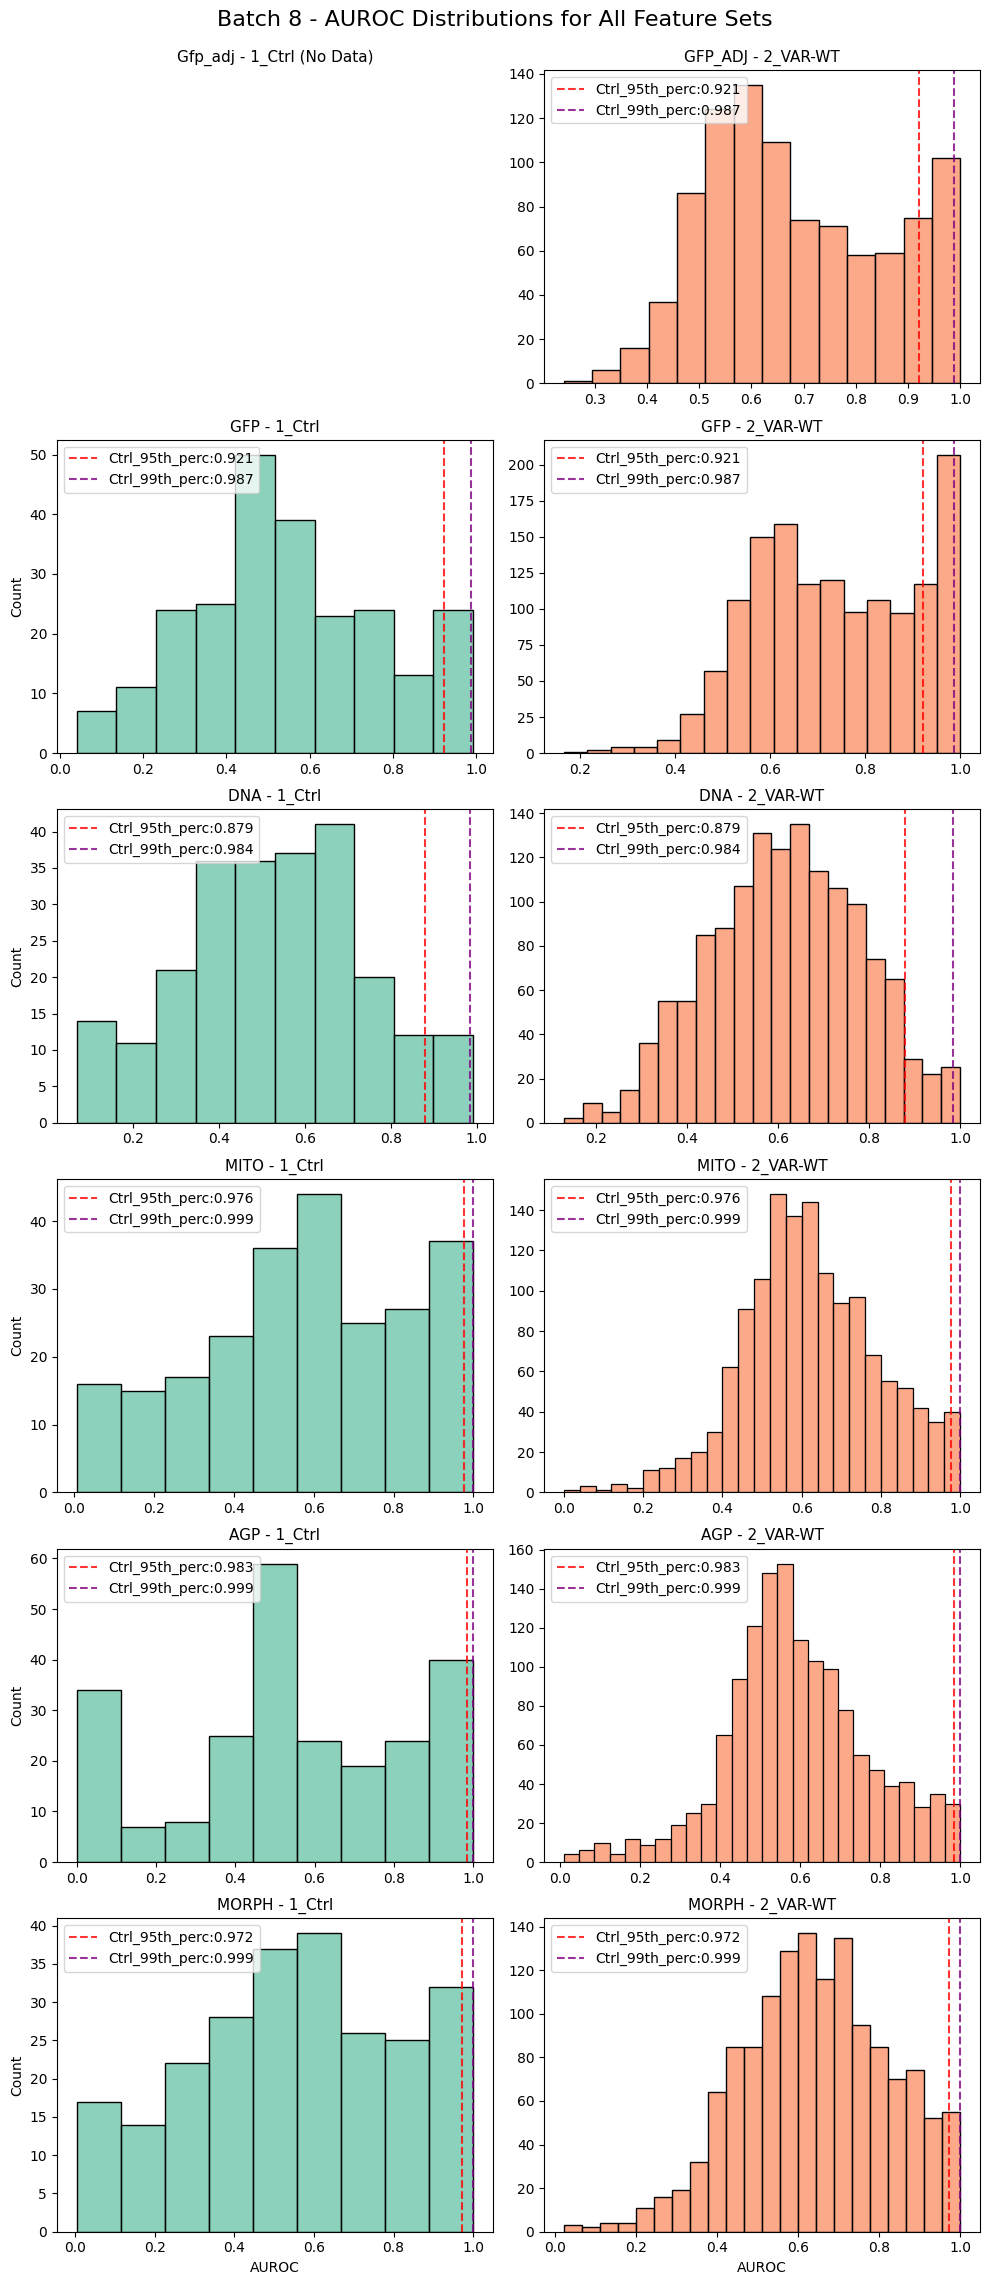

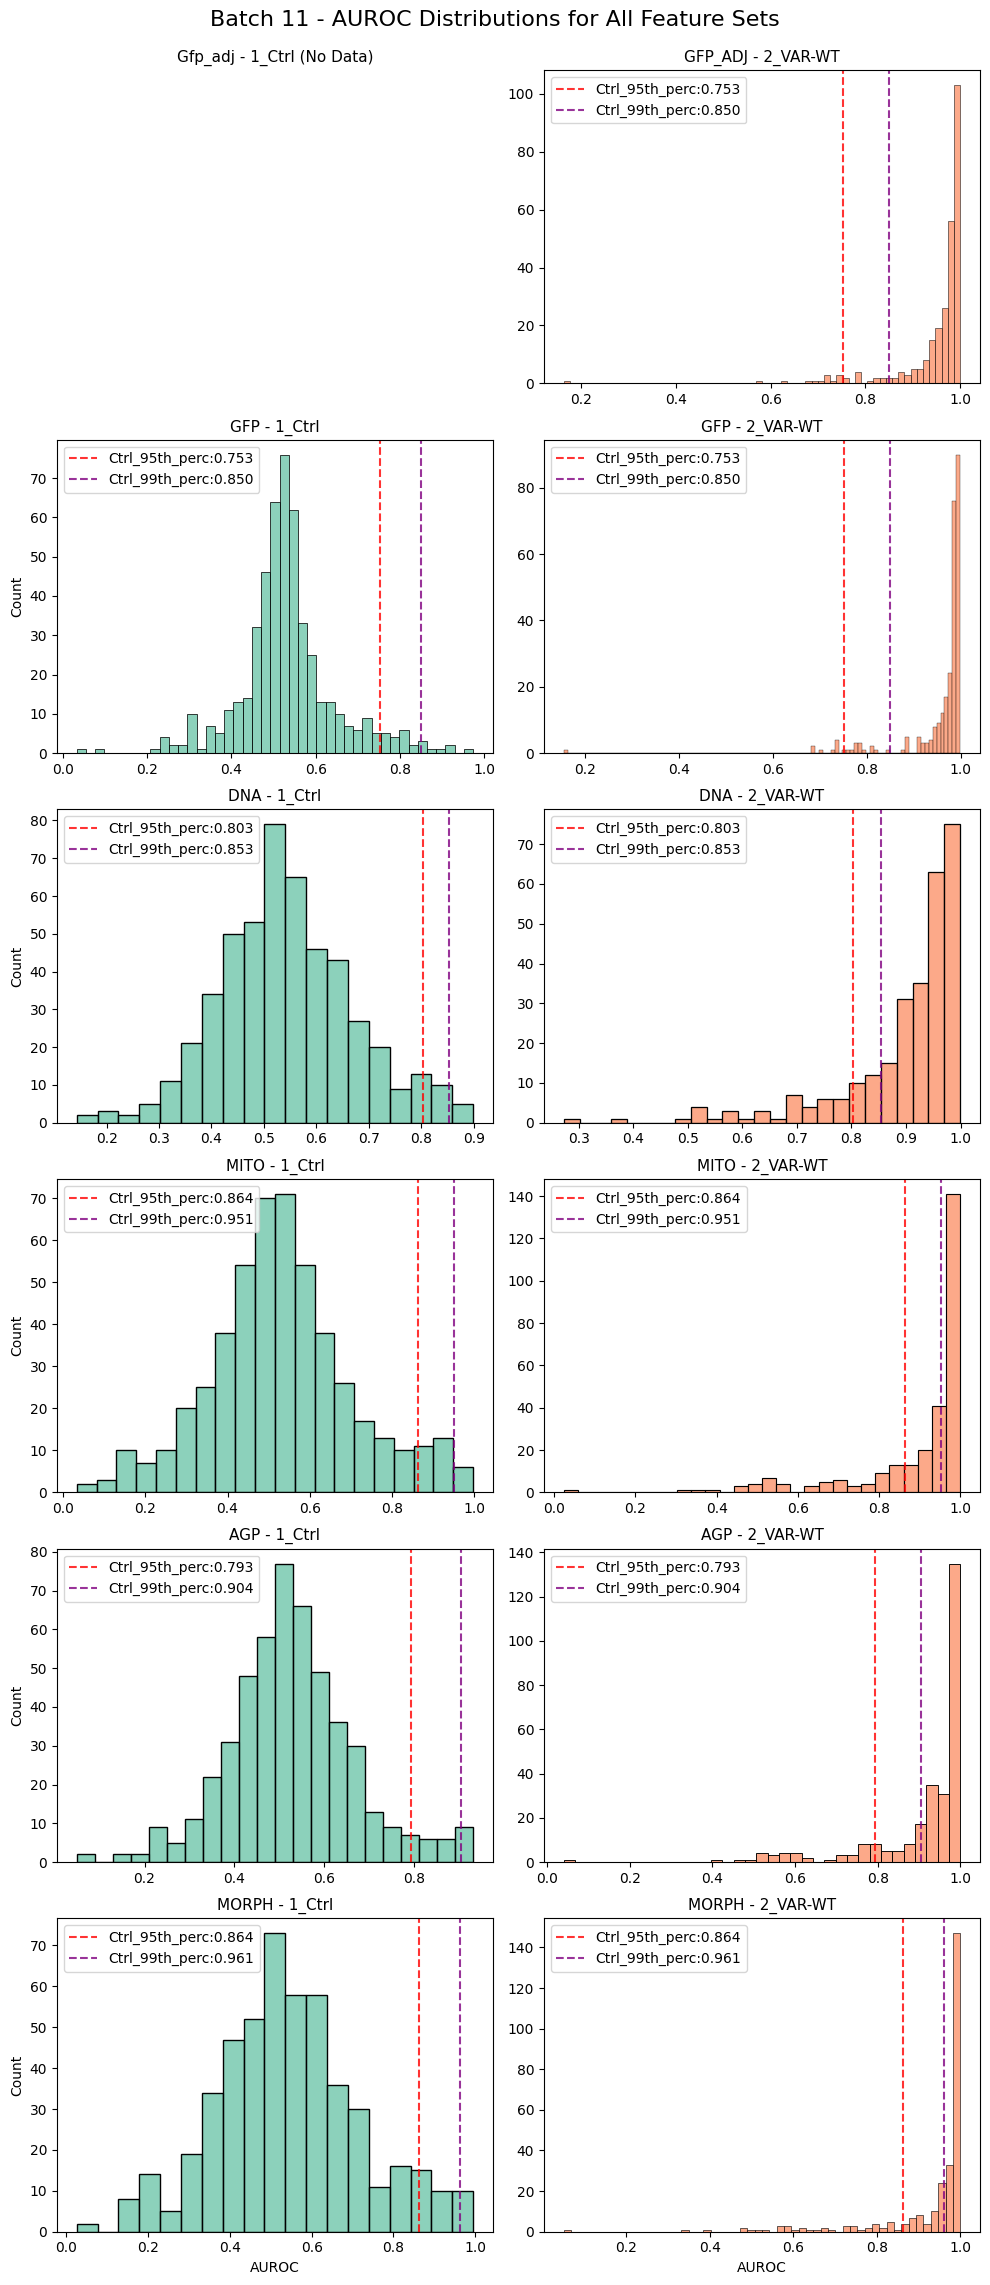

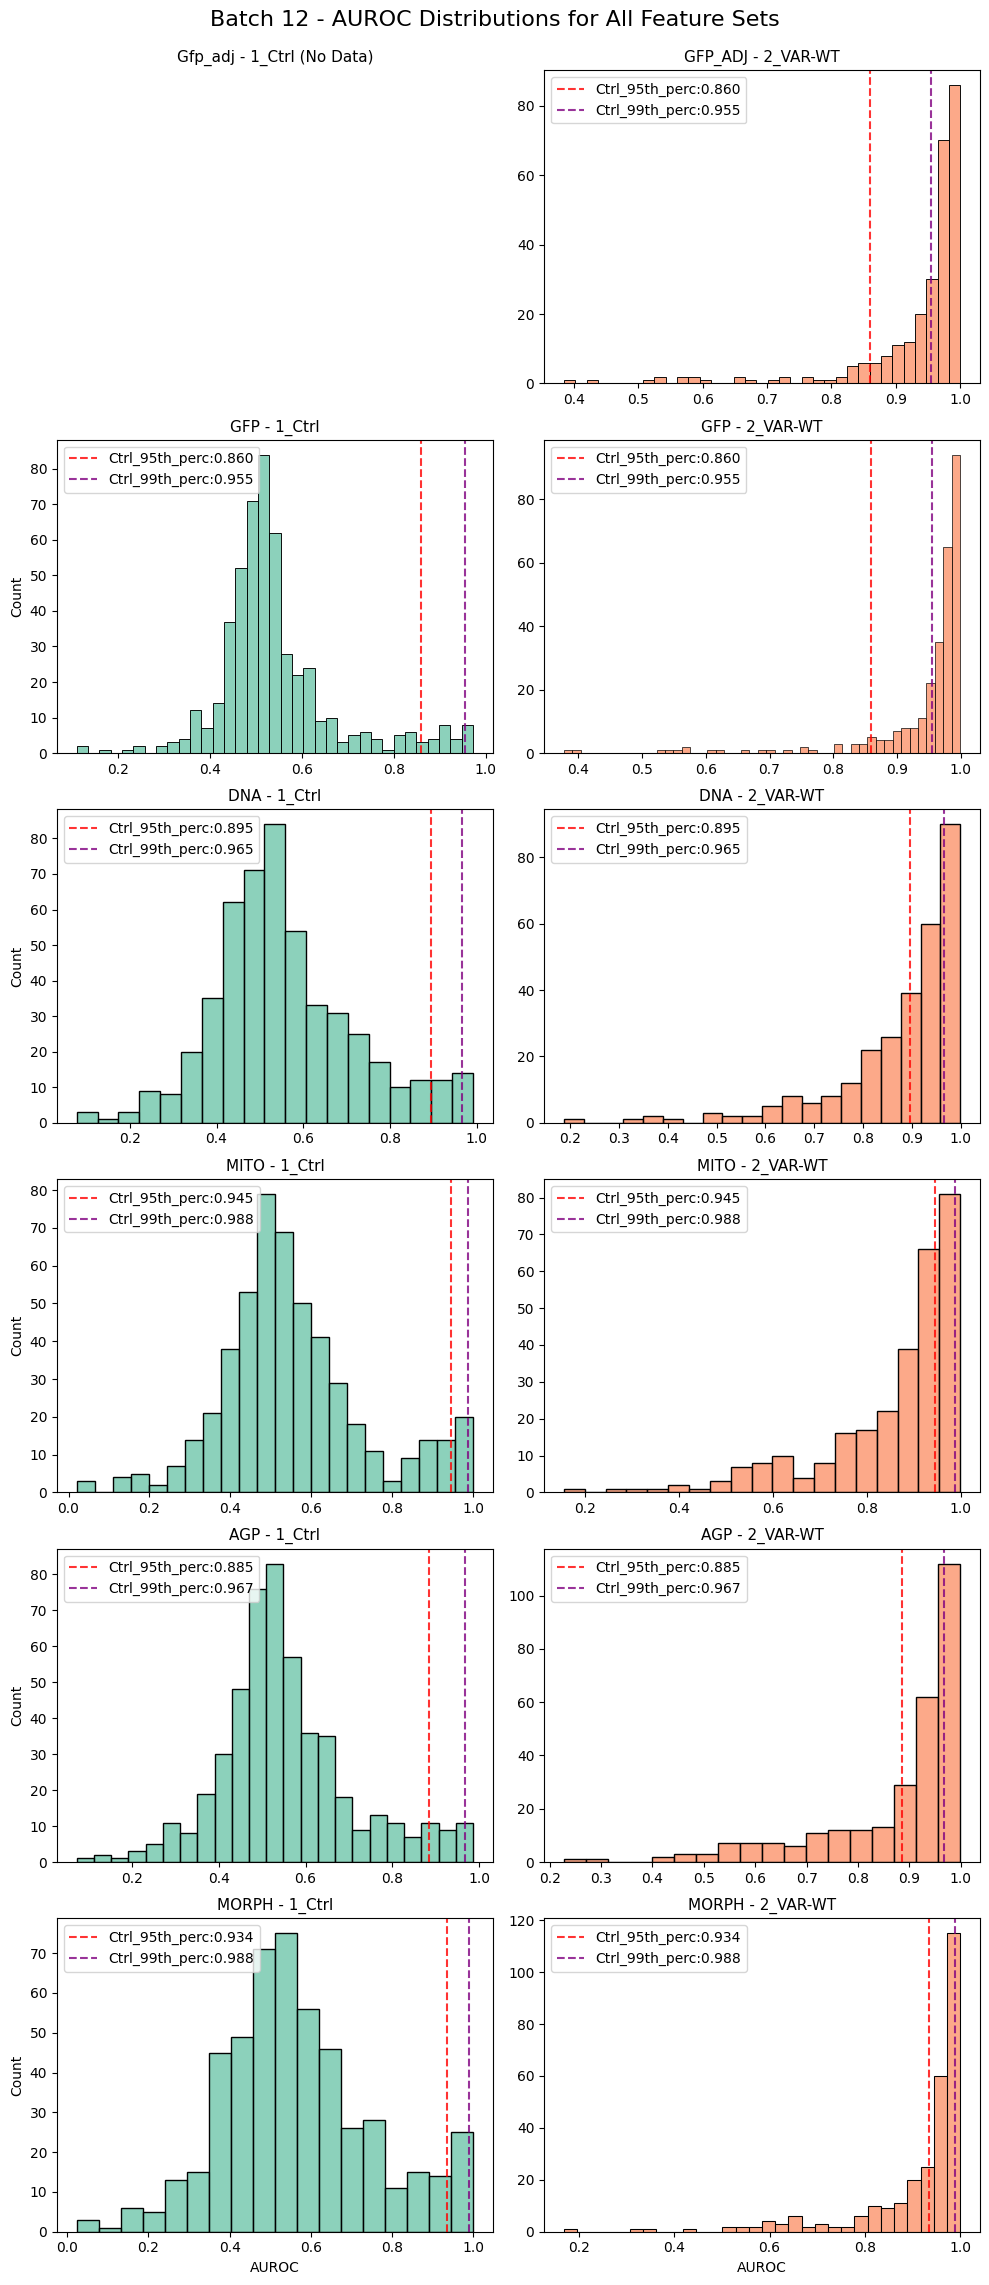

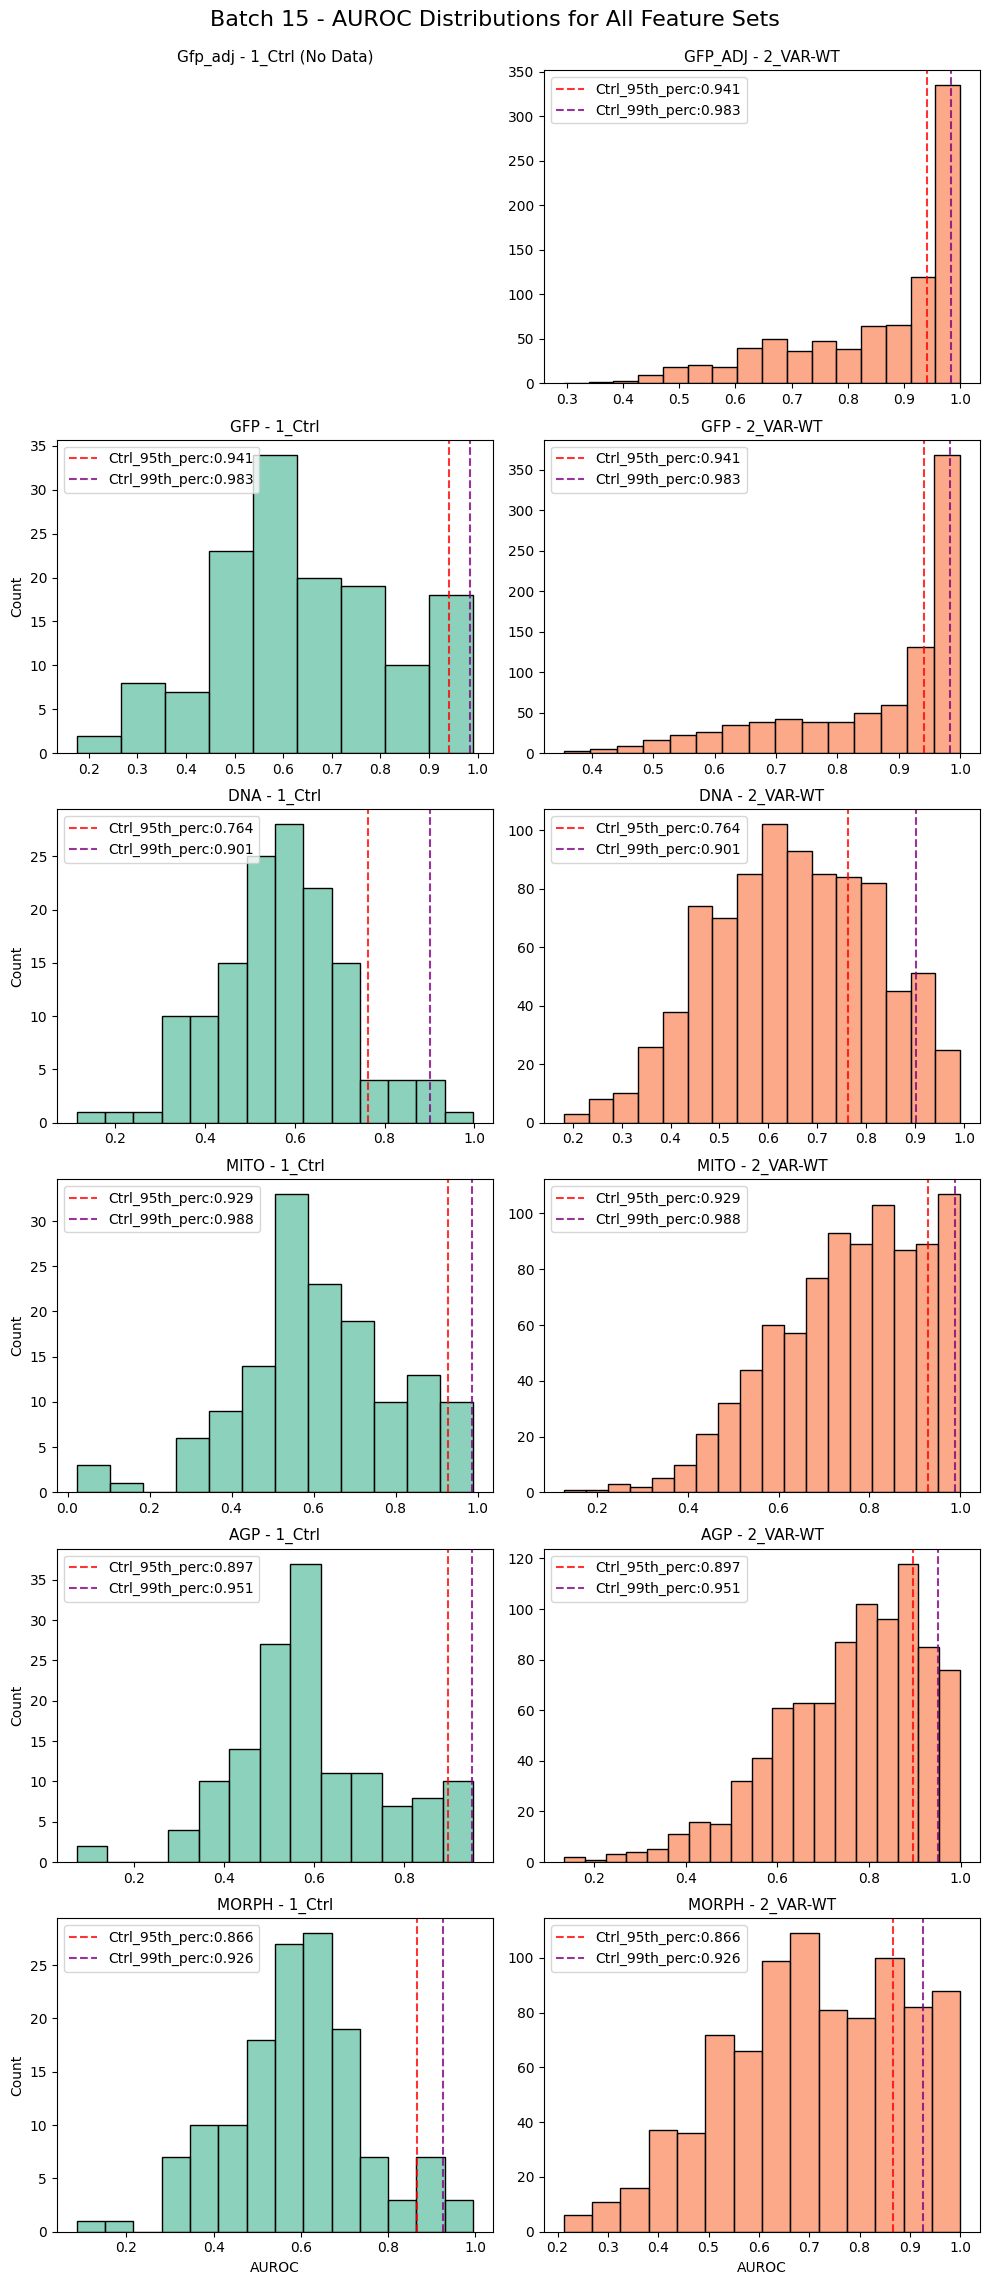

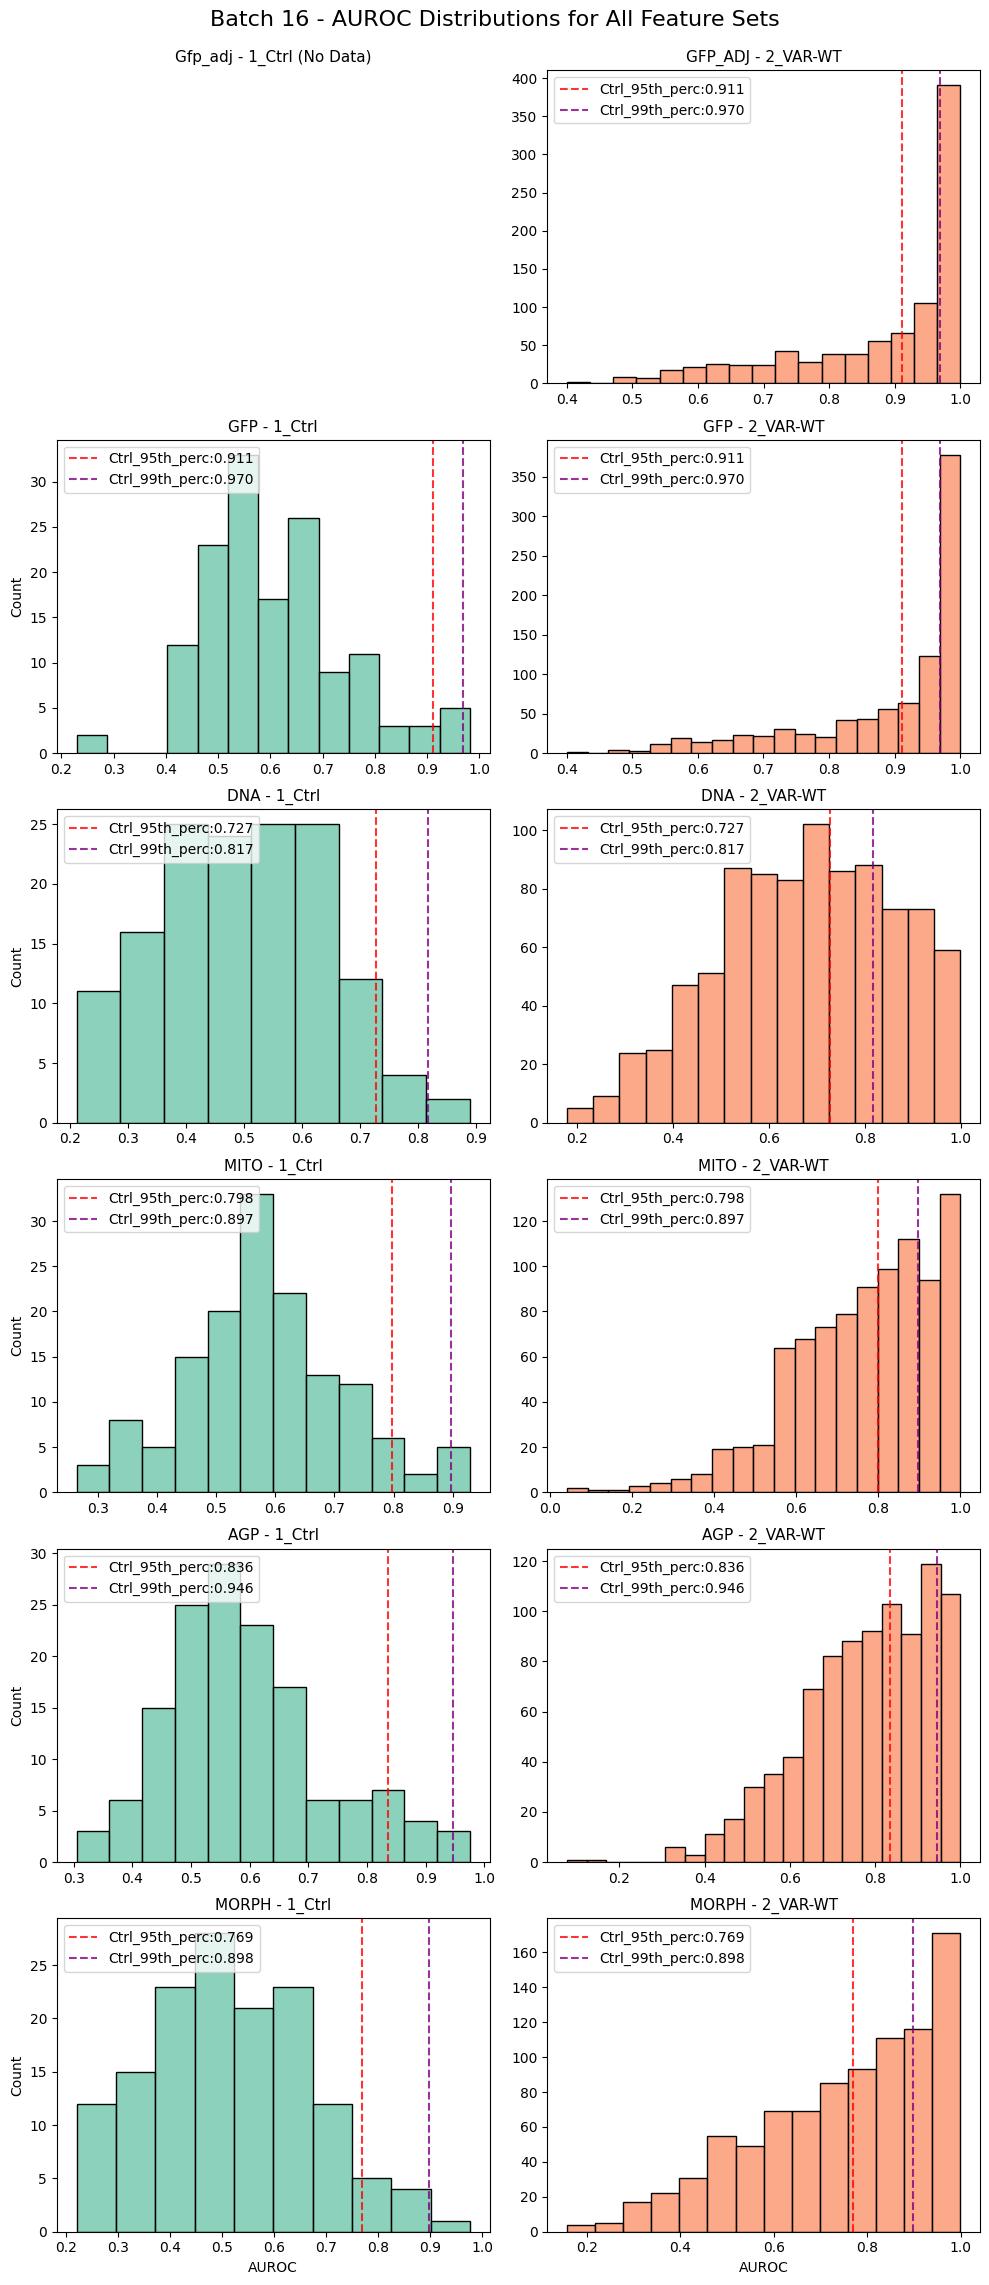

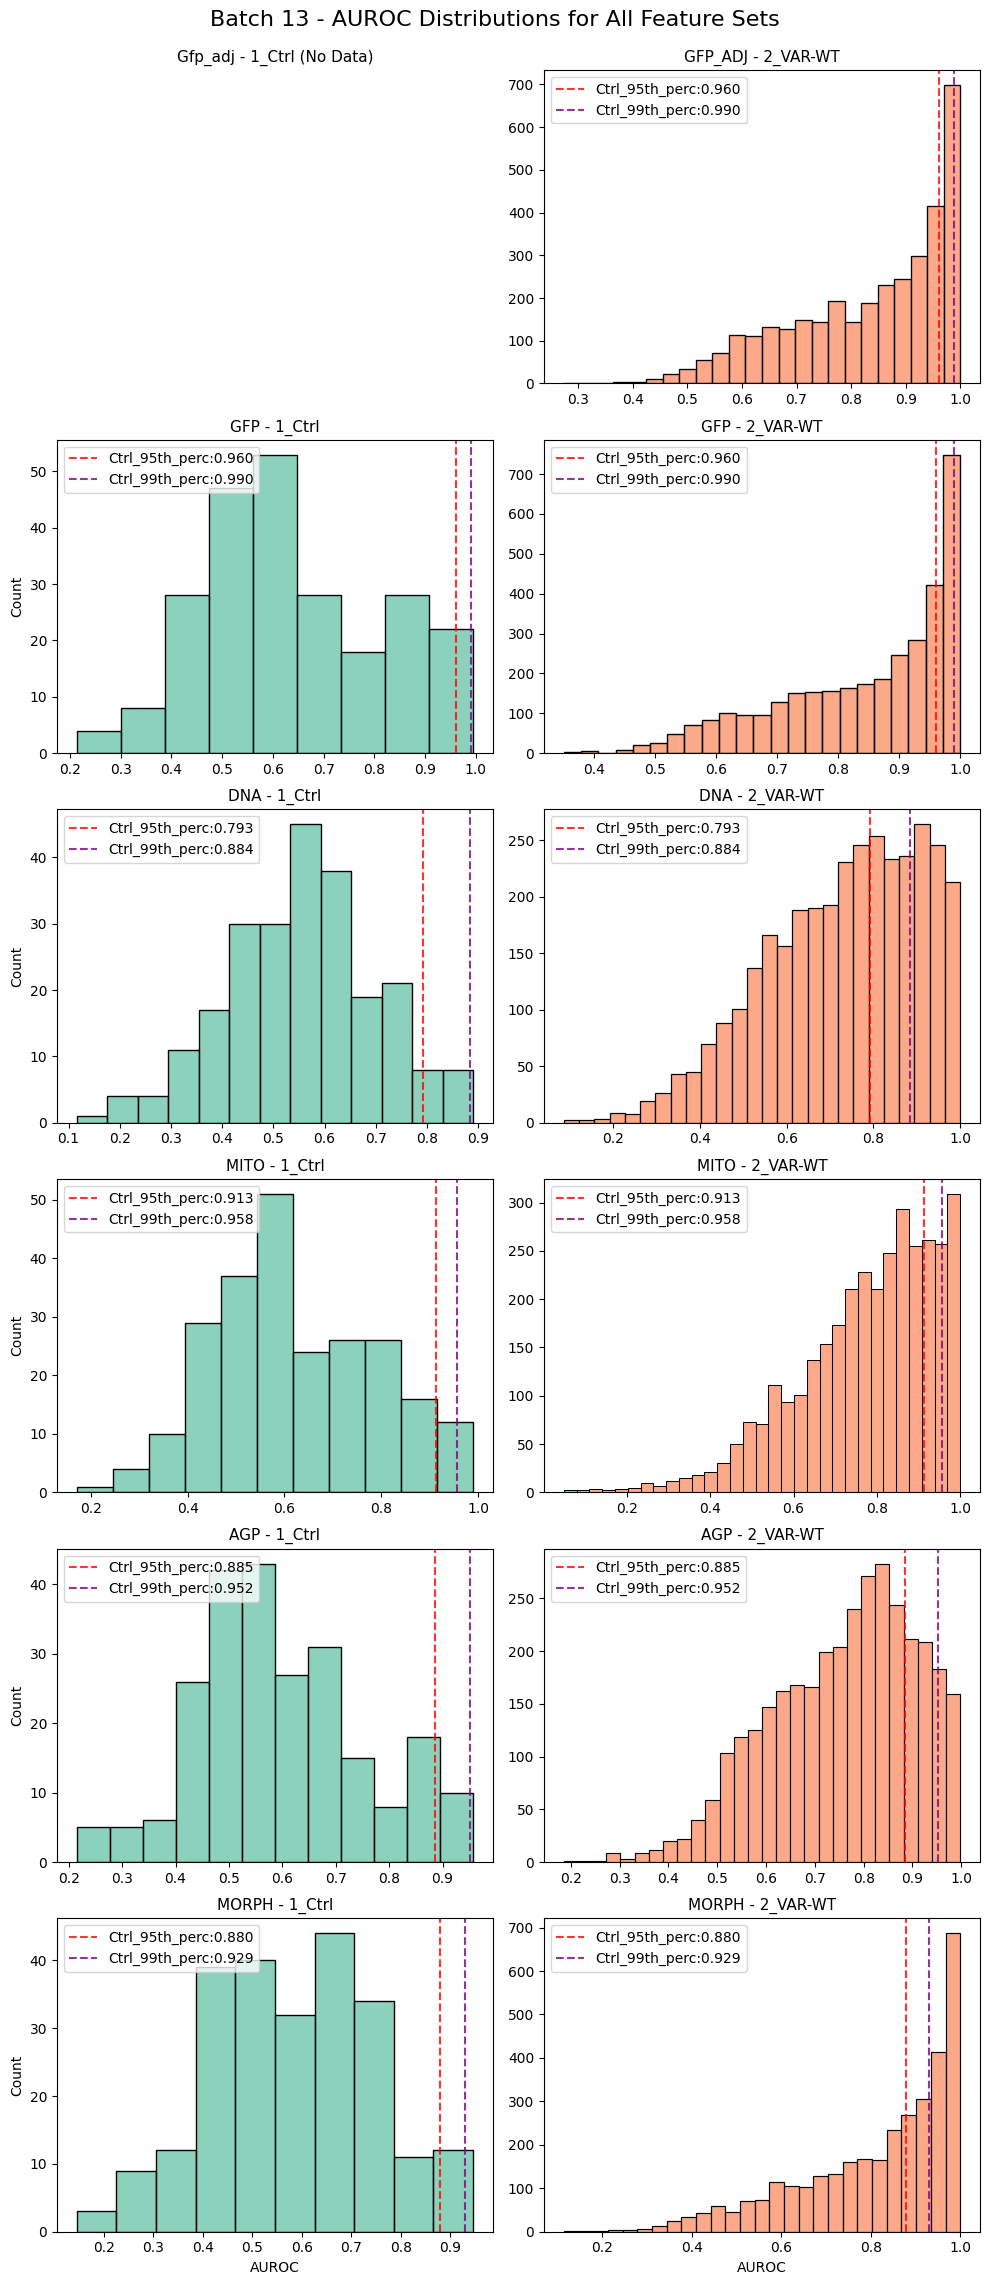

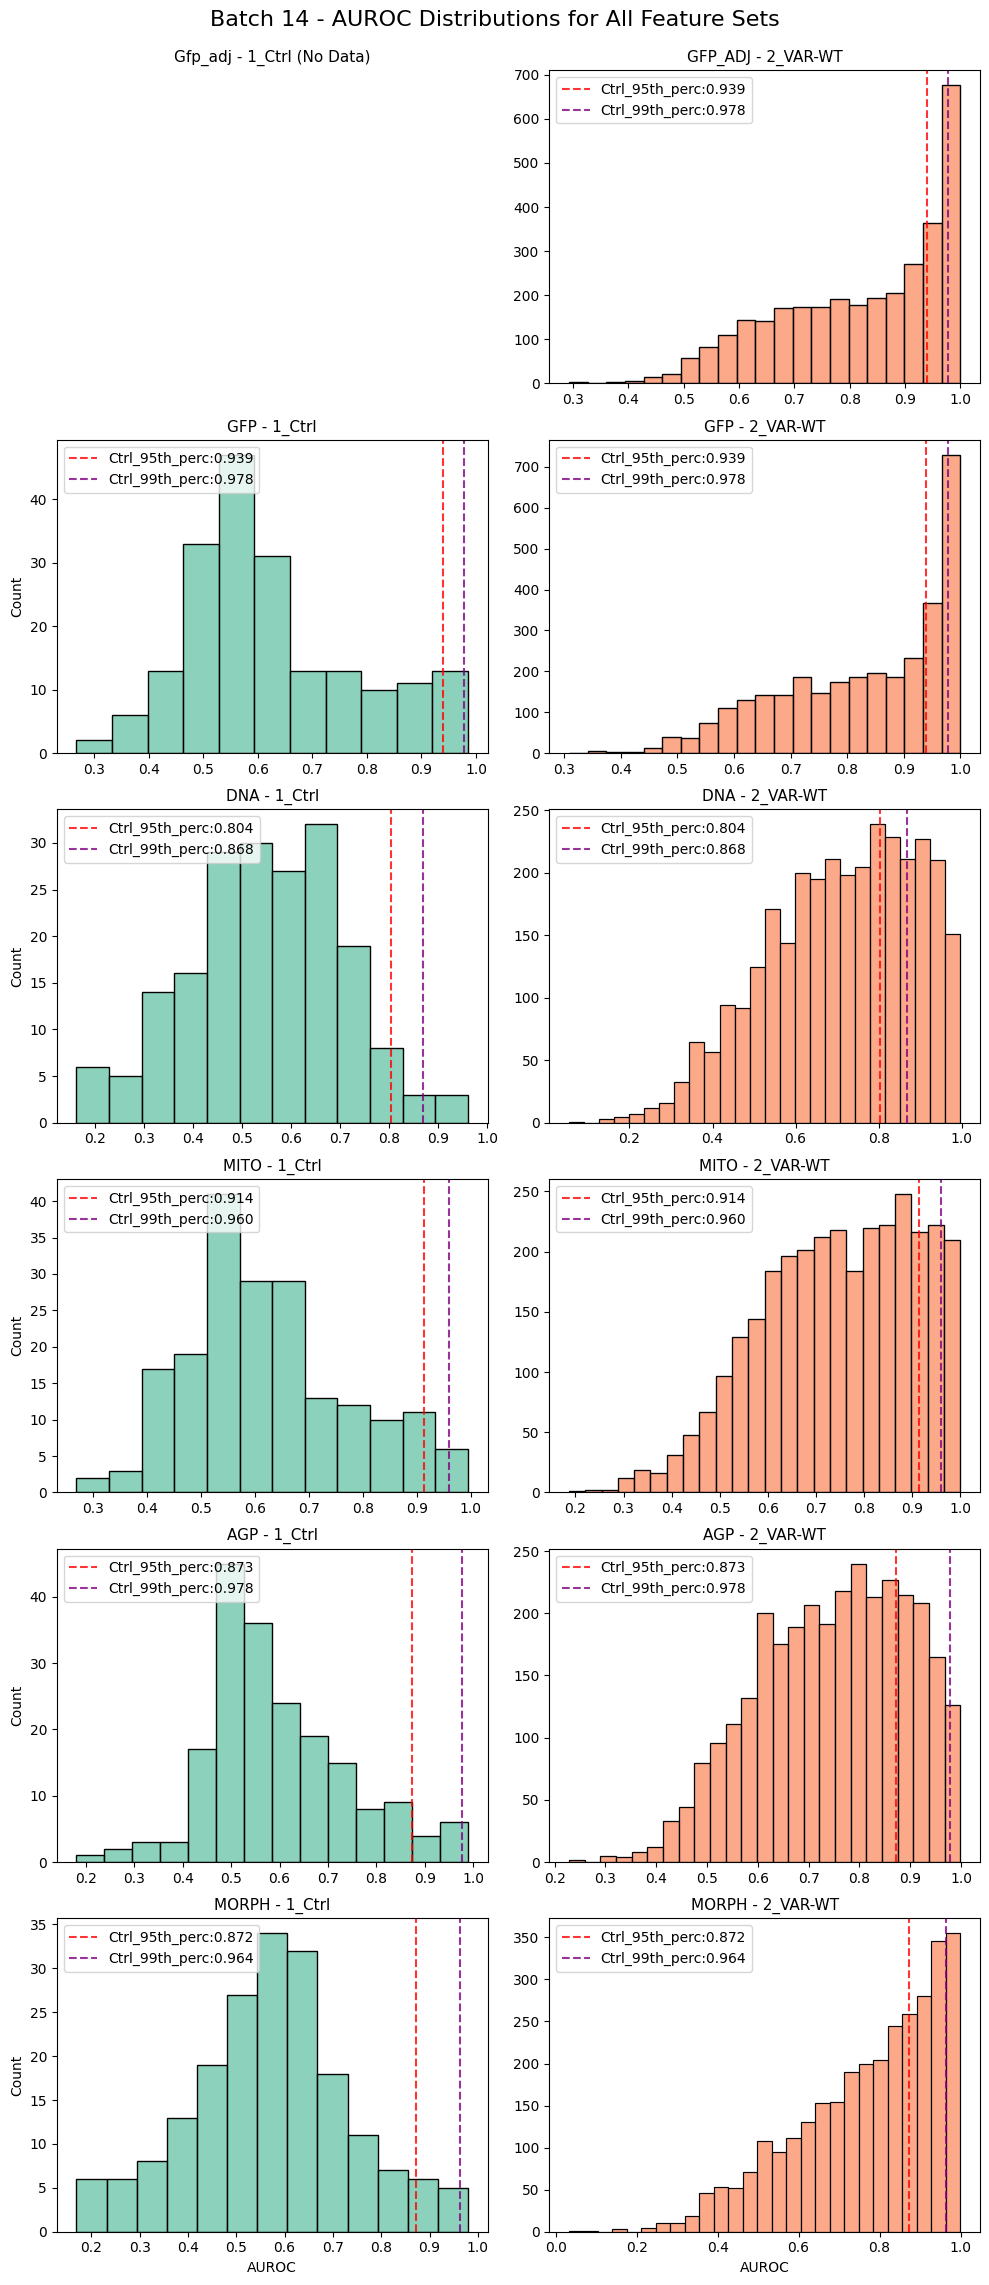

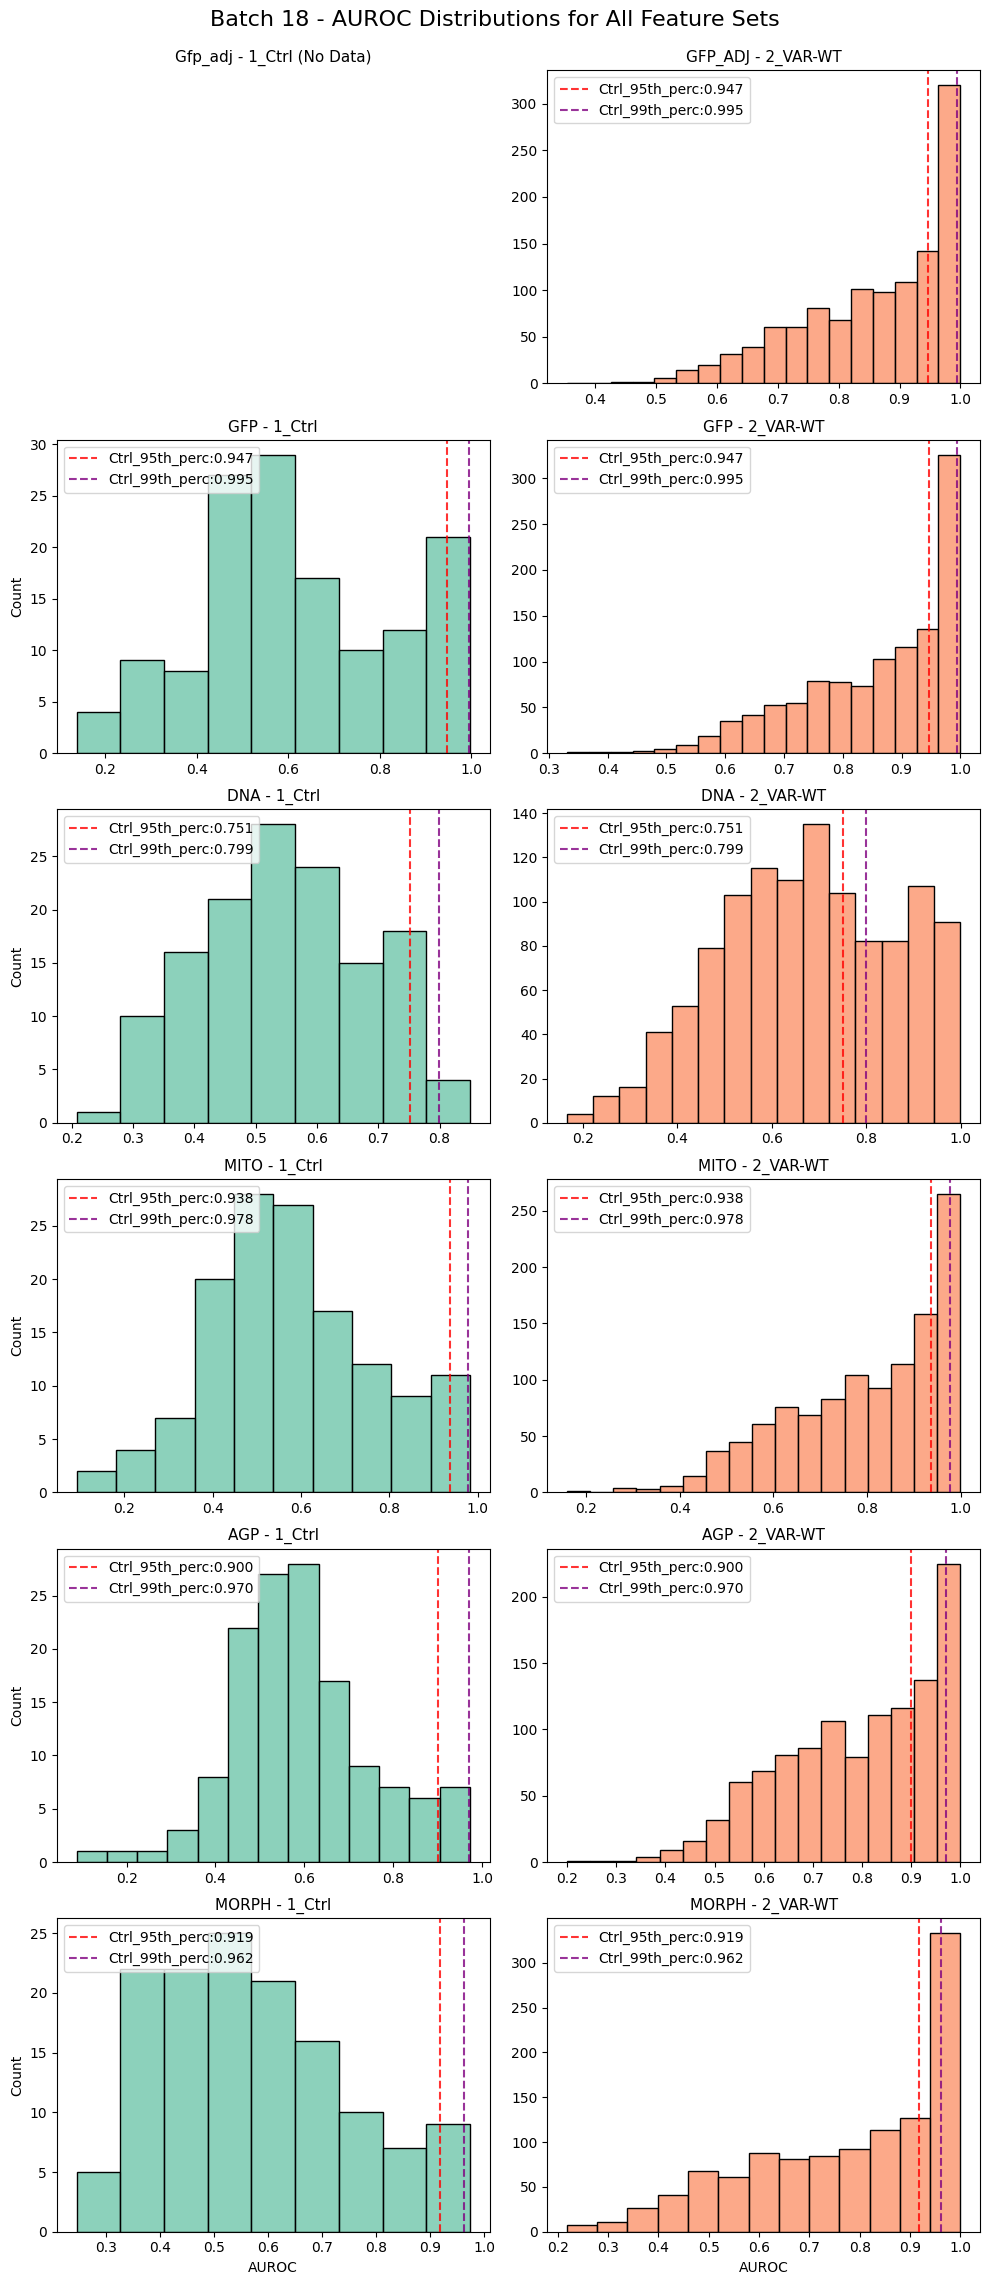

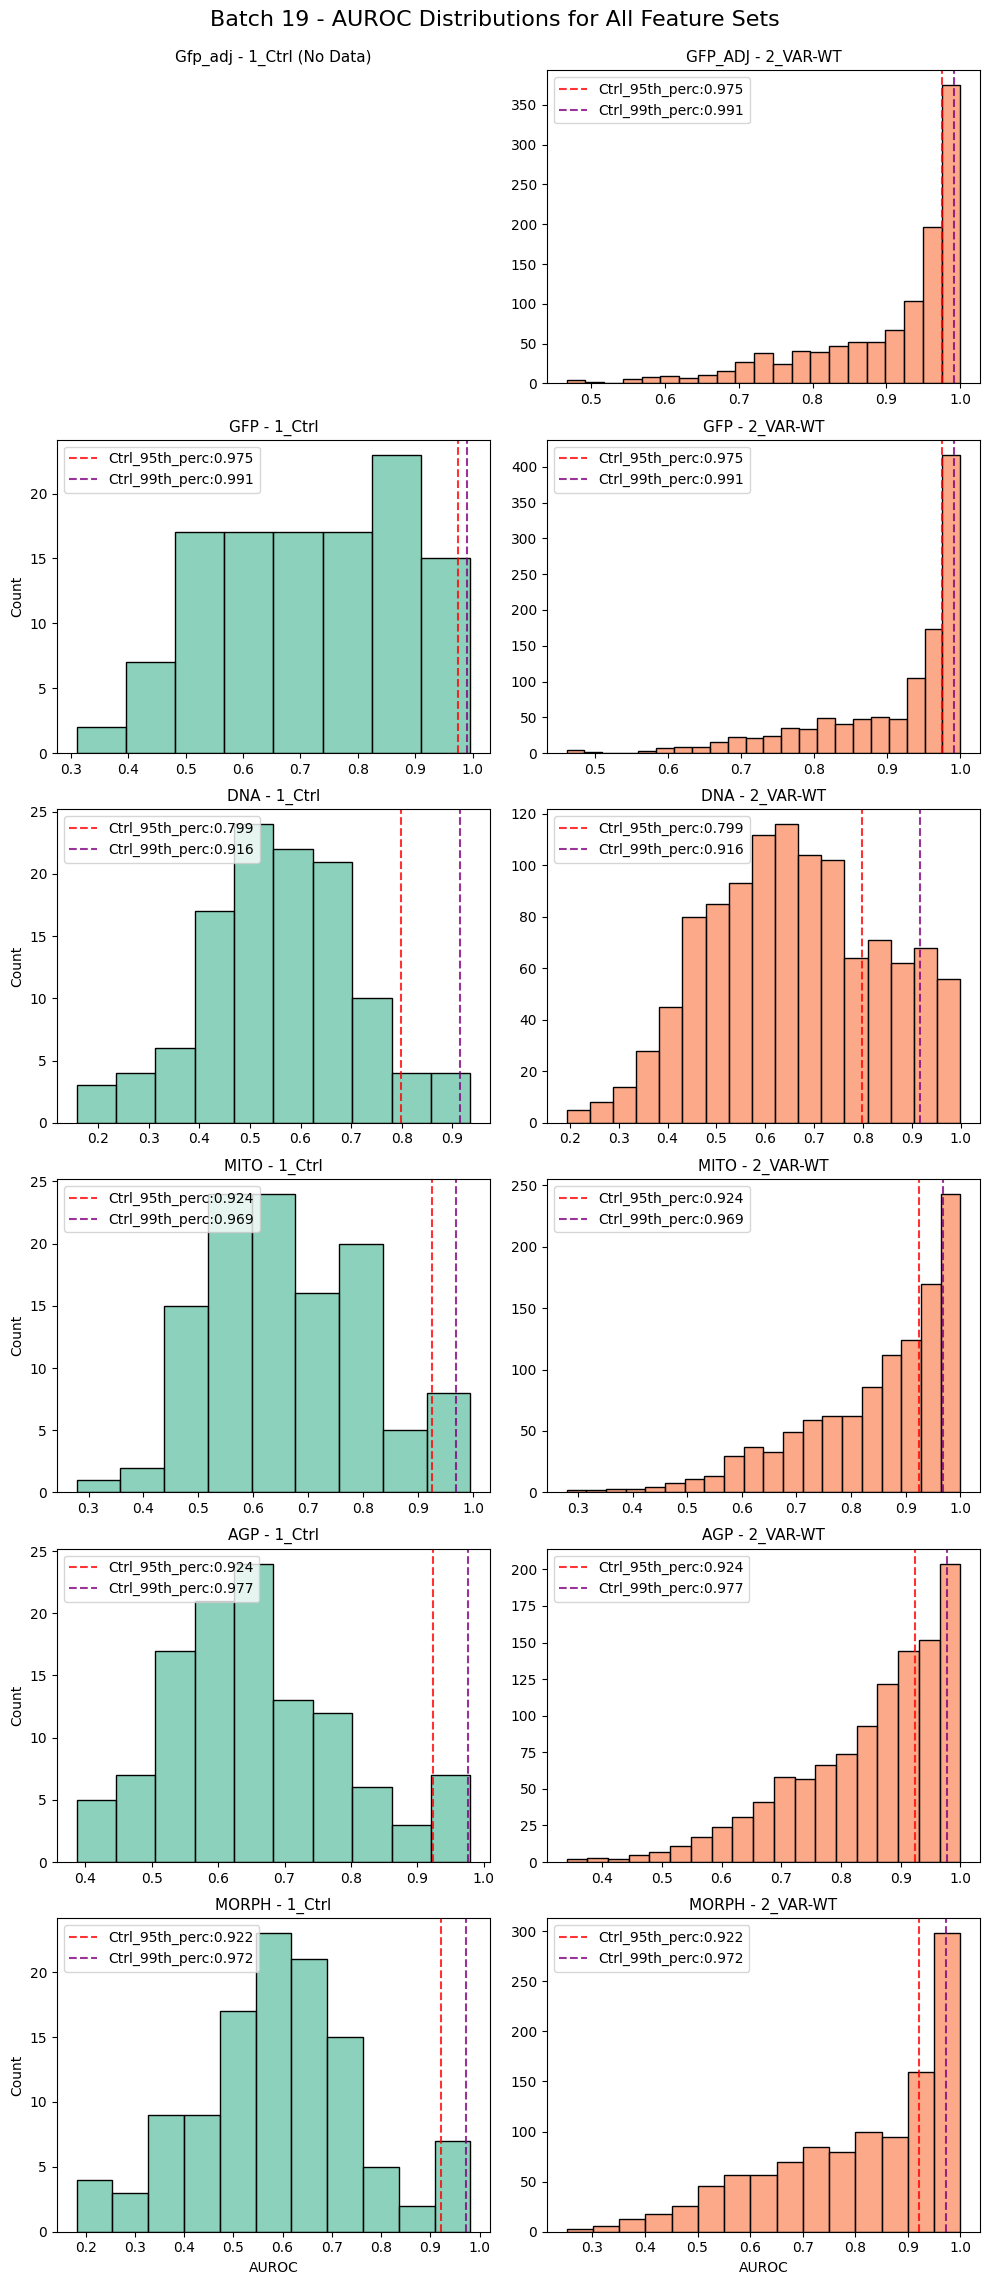

In [26]:
# Get dimensions for subplot grid
n_changes = len(FEAT_SETS) + 1
n_node_types = len(sorted(metrics_df['Node_Type'].unique()))
node_types_sorted = sorted(metrics_df['Node_Type'].unique())

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_num = batch_id.split("_")[-1]
        # Create figure with subplots for this batch
        fig, axes = plt.subplots(
            n_changes, n_node_types, 
            figsize=(5 * n_node_types, 4 * n_changes),
            squeeze=False
        )
        for change_idx, change in enumerate(["GFP_ADJ"]+FEAT_SETS):
            ## Only need to plot for one change, since the other is duplicative
            # if change == "GFP":
            #     df_local = metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change)
            #     plot_metric_dist(df_local, value="Training_imbalance", batch=batch_num, col="Node_Type")
            #     plot_metric_dist(df_local, value="trainsize_0", batch=batch_num, col="Node_Type")
            #     plot_metric_dist(df_local, value="trainsize_1", batch=batch_num, col="Node_Type")
            perc_dict = dict([(
                f"{auroc_thres*100:.0f}th_perc", 
                metric_df_dict[f"B{batch_num}_met_thres"].filter(
                    pl.col("Classifier_type") == change
                ).select(f"AUROC_thresh_{auroc_thres*100:.0f}").mean().to_numpy()[0][0]
            ) for auroc_thres in AUROC_THRESHOLDS])
    
            # Get filtered data for this batch and change
            plot_data = metric_df_dict[f"B{batch_num}_met_thres"].filter(
                (pl.col("Classifier_type") == change) & 
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            ).to_pandas()
            
            # Create subplot for each node type
            for node_idx, node_type in enumerate(node_types_sorted):
                ax = axes[change_idx, node_idx]
                # Filter data for this node type
                node_data = plot_data[plot_data['Node_Type'] == node_type]
                if not node_data.empty:
                    # Create histogram
                    sns.histplot(
                        data=node_data,
                        x="AUROC",
                        kde=False,
                        ax=ax,
                        color=sns.color_palette("Set2")[node_idx % len(sns.color_palette("Set2"))]
                    )                
                    # Add vertical lines for thresholds
                    colors = ['red', 'purple', 'orange', 'brown']  # Different colors for different thresholds
                    for i, (label, auroc_val) in enumerate(perc_dict.items()):
                        color = colors[i % len(colors)]
                        ax.axvline(auroc_val, color=color, linestyle='--', alpha=0.8, label=f"Ctrl_{label}:{auroc_val:.3f}")
                    ax.legend(loc="upper left")
                    # Set title and labels
                    ax.set_title(f"{change.upper()} - {node_type}", fontsize=11)
                    # Add legend only to the first subplot
                    # if change_idx == 0 and node_idx == 0:
                    #     ax.legend(loc='upper right', fontsize=8)
                else:
                    ax.set_title(f"{change.capitalize()} - {node_type} (No Data)", fontsize=11)
                    ax.axis('off')
                
                # Set labels
                if change_idx == n_changes - 1:  # Bottom row
                    ax.set_xlabel("AUROC")
                else:
                    ax.set_xlabel("")
                    
                if node_idx == 0:  # Left column
                    ax.set_ylabel("Count")
                else:
                    ax.set_ylabel("")
        
        # Add overall title for the batch
        fig.suptitle(f"Batch {batch_num} - AUROC Distributions for All Feature Sets", 
                     fontsize=16, y=0.95)
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=.925)

        # os.makedirs(f"{CLASS_SUMMARY_DIR}/{bio_rep}", exist_ok=True)
        fig.savefig(
            os.path.join(f"{CLASS_SUMMARY_DIR}/{bio_rep}/B{batch_num}_ctrl_var-wt_dist.png"),
            dpi=300,
            bbox_inches="tight"
        )

### 3.1 Correlation between biological replicates

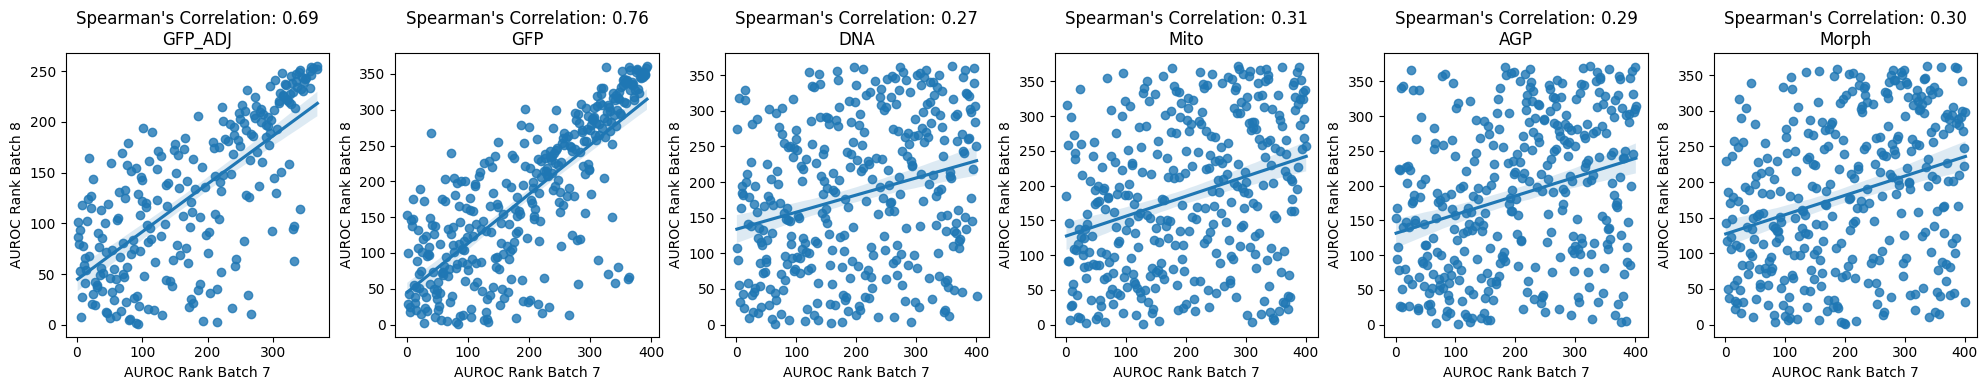

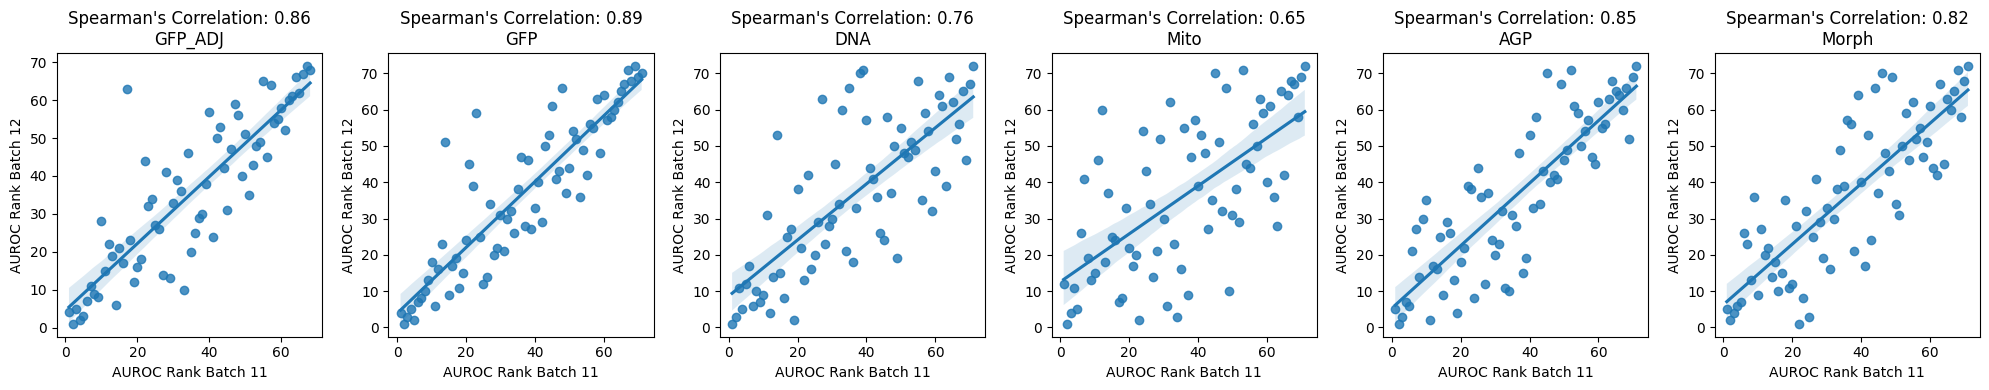

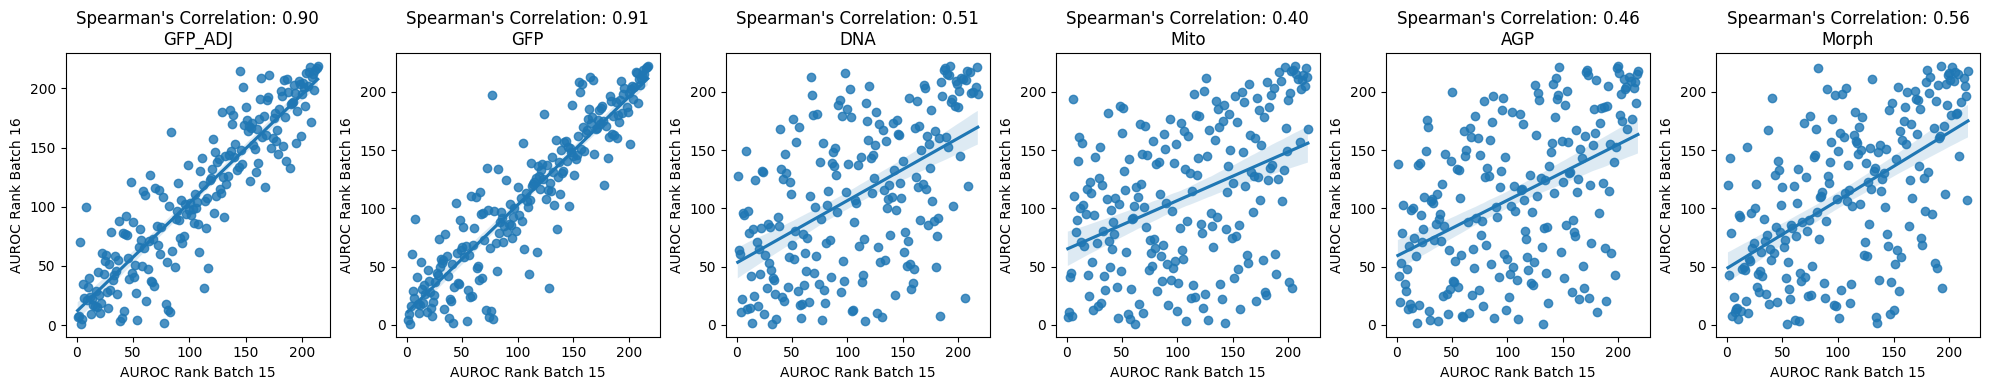

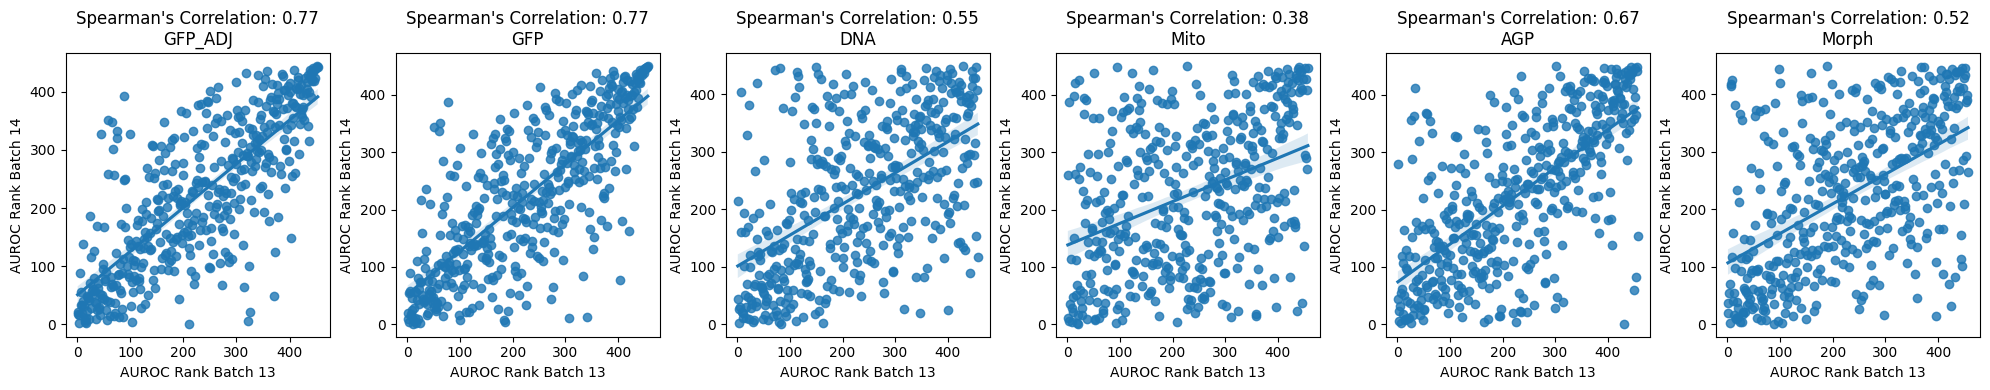

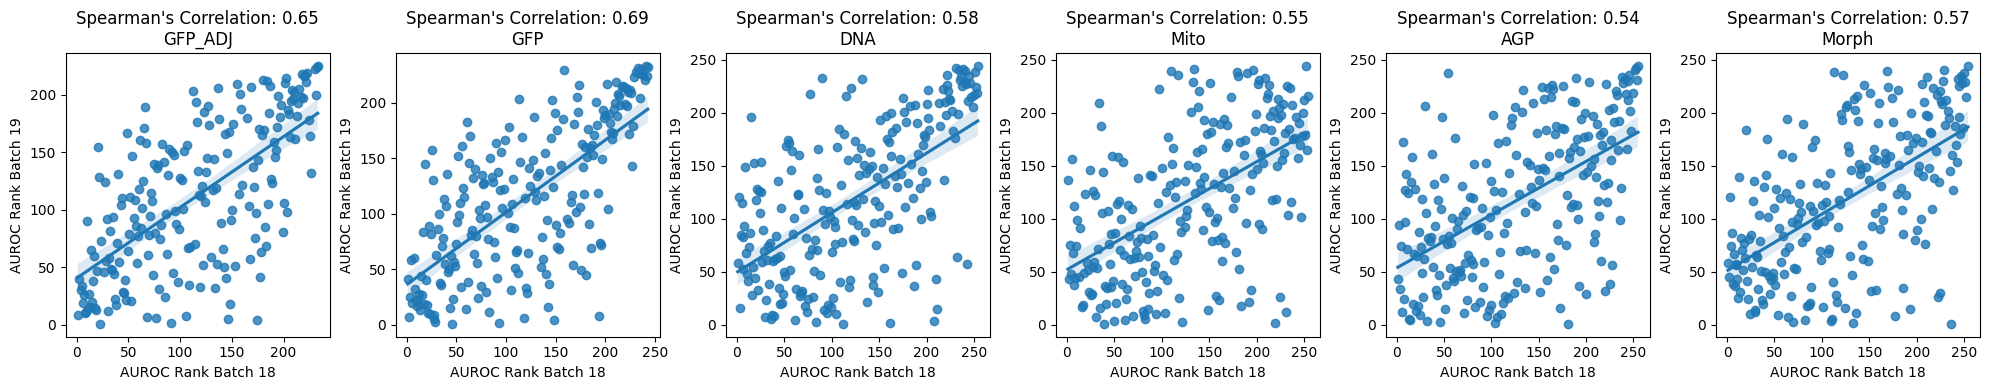

In [28]:
from scipy.stats import spearmanr

plot_feats = ["GFP_ADJ"]+FEAT_SETS
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    fig, axes = plt.subplots(1, 6, figsize=(20,4))
    for classifier_type in plot_feats:
        # Select the columns "allele_0" and "AUROC_rank" from both dataframes
        set1_ranks = metric_df_dict[f"B{bio_rep_batches[0].split('_')[-1]}_allele_summary"].filter(
            (pl.col("Classifier_type") == classifier_type)
        ).with_columns(
            pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
        ).select(["allele_0", "AUROC_rank"])
        set2_ranks = metric_df_dict[f"B{bio_rep_batches[1].split('_')[-1]}_allele_summary"].filter(
            (pl.col("Classifier_type") == classifier_type)
        ).with_columns(
            pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
        ).select(["allele_0", "AUROC_rank"])
    
        # print(classifier_type, set1_ranks, set1_ranks)
        # Join the dataframes on the "allele_0" column
        joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_rep2")
        # print(joined_ranks.sort(by="allele_0"))
        # Calculate the Spearman's correlation between the ranks
        spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_rep2"])
        # print(f"Spearman's correlation: {spearman_corr}")
    
        # bio_rep1_thres = metric_df_dict["B13_allele_summary"].filter(
        #     (pl.col("Classifier_type") == classifier_type)
        # )['AUROC_thresh'].unique()[0]
        # bio_rep2_thres = metric_df_dict["B14_allele_summary"].filter(
        #     (pl.col("Classifier_type") == classifier_type)
        # )['AUROC_thresh'].unique()[0]
        
        # Plot the correlation using a regression plot
        sns.regplot(x="AUROC_rank", y="AUROC_rank_rep2", data=joined_ranks.to_pandas(), ax=axes[plot_feats.index(classifier_type)])
        # axes[FEAT_SETS.index(classifier_type)].axvline(bio_rep1_thres, linestyle="dashed", color="tomato")
        # axes[FEAT_SETS.index(classifier_type)].axhline(bio_rep2_thres, linestyle="dashed", color="tomato")
        axes[plot_feats.index(classifier_type)].set_title(f"Spearman's Correlation: {spearman_corr:.2f}\n{classifier_type}")
        axes[plot_feats.index(classifier_type)].set_xlabel(f"AUROC Rank Batch {bio_rep_batches[0].split('_')[-1]}")
        axes[plot_feats.index(classifier_type)].set_ylabel(f"AUROC Rank Batch {bio_rep_batches[1].split('_')[-1]}")
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=.25)
    plt.savefig(
        os.path.join(f"{CLASS_SUMMARY_DIR}/{bio_rep}/AUROC_rank_correlation.png"),
        dpi=300,
        bbox_inches="tight"
    )

In [26]:
# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     # display(platemap_df)
#     for key, df in metric_df_dict.items():
#         # print(key)
#         if "met_thres" in key:
#             for plate in df["Plate"].unique():
#                 print(plate)
#                 auroc_platemap = platemap_df.with_columns(
#                         pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                 ).join(
#                     df.filter((pl.col("Plate")==plate)&(pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                         pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                     ),
#                     left_on="well_allele", right_on="well_allele", how="left"
#                 ).filter(pl.col("AUROC").is_not_null())
#                 # display(auroc_platemap)
#                 plot_platemap(
#                     auroc_platemap,
#                     plate_name=plate,
#                     well_pos_col="well_position",
#                     value_col="AUROC",
#                     label_cols=("gene_allele","AUROC"),
#                     value_type="continuous",
#                     continuous_cmap="viridis_r"
#                 )

# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     for key, df in metric_df_dict.items():
#         if "met_thres" in key:
#             for change in CELL_CHANGES:
#                 df_chg = df.filter(pl.col("Classifier_type") == change)
#                 for plate in df_chg["Plate"].unique():
#                     # print(plate)
#                     auroc_platemap = platemap_df.with_columns(
#                             pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                     ).join(
#                         df_chg.filter((pl.col("Plate")==plate)&(~pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                             pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                         ),
#                         left_on="well_allele", right_on="well_allele", how="left"
#                     ).filter(pl.col("AUROC").is_not_null())
#                     # display(auroc_platemap)
#                     plot_platemap(
#                         auroc_platemap,
#                         plate_name=f"{plate}_{change}",
#                         well_pos_col="well_position",
#                         value_col="AUROC",
#                         label_cols=("gene_allele","AUROC"),
#                         value_type="continuous",
#                         continuous_cmap="viridis_r"
#                     )

## 4. Calling hits

In [27]:
# def plot_gene_level_summary(total_allele_hit_sum_df, cell_change, auroc_thres):
#     # 1. Fill nulls with 0
#     total_allele_hit_sum_df["len_hits"] = total_allele_hit_sum_df["len_hits"].fillna(0).astype(int)
#     # 2. Compute percentage of hits
#     total_allele_hit_sum_df["pct_hits"] = total_allele_hit_sum_df["len_hits"] / total_allele_hit_sum_df["len"] * 100
#     # 3. Sort by percentage descending
#     total_allele_hit_sum_df = total_allele_hit_sum_df.sort_values(by=["len","pct_hits"], ascending=True).reset_index(drop=True)
    
#     y = range(len(total_allele_hit_sum_df))
#     n_genes = len(y)

#     # 4. Dynamically scale figure size
#     bar_width = 0.4
#     fig_height = max(6, min(n_genes * 0.3, 25))  # cap size for huge plots
#     fig_width = 8
#     fig, ax = plt.subplots(figsize=(fig_width, fig_height))
#     # Plot bars
#     ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
#     ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

#     # Annotate percentage
#     for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
#         ax.text(
#             total_allele_hit_sum_df.loc[i, "len"] + 0.5,
#             i,
#             f"{pct:.1f}%",
#             ha="left",
#             va="center",
#             fontsize=10 if n_genes > 20 else 11,
#             rotation=0,
#         )
#     # Axis formatting
#     ax.set_yticks(y)
#     ax.set_yticklabels(
#         total_allele_hit_sum_df["by"],
#         fontsize=10 if n_genes > 20 else 11,
#     )
#     ax.set_xlabel("Count", fontsize=11)
#     ax.set_title(
#         f"Altered {cell_change.capitalize()} Hits per Gene (AUROC thres: {auroc_thres})",
#         fontsize=13,
#     )
#     ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
#     ax.set_ylim(-1, len(y) + .3)
#     ax.legend(fontsize=11, loc="lower right")
#     # Improve spacing
#     plt.tight_layout()
#     plt.show()
#     return total_allele_hit_sum_df

### 4.1 Call hits per each batch

In [33]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    metric_sum_df_dict = {}
    for met_sum_file in glob.glob(f"{CLASS_INTERIM_DIR}/{bio_rep}/*/*.csv"):
        metric_sum_df_dict[met_sum_file.split('/')[-2]] = pl.read_csv(met_sum_file)
    metrics_sum_wtvar = pl.concat(list(metric_sum_df_dict.values()))
    for cell_change in ["GFP_ADJ"]+FEAT_SETS:
        ## Filter the change to detect
        cell_chg_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == cell_change)
        ## Per each batch, get the hits
        cell_chg_wtvar = cell_chg_wtvar.with_columns([
            pl.when(pl.col("AUROC_mean") > pl.col(f"AUROC_thresh_{auroc*100:.0f}"))
            .then(1)
            .otherwise(0)
            .alias(f"Altered_{cell_change}_{auroc*100:.0f}")
            for auroc in AUROC_THRESHOLDS
        ]).unique()
    
        ## Create separate pivot tables for each threshold and combine them
        all_threshold_dfs = []
        for auroc in AUROC_THRESHOLDS:
            threshold_name = f"{auroc*100:.0f}"
            # Create pivot for this threshold
            threshold_df = (
                cell_chg_wtvar.pivot(
                    index=["allele_0"],
                    on="Batch",
                    values=f"Altered_{cell_change}_{threshold_name}",
                )
                # Rename batch columns to include threshold
                .rename({
                    f"B{batch.split('_')[-1]}": f"Altered_{cell_change}_{threshold_name}_BioRep{idx+1}"
                    for idx, batch in enumerate(bio_rep_batches)
                })
                .with_columns(
                    # Create a list of batch columns
                    pl.concat_list([
                        pl.col(f"Altered_{cell_change}_{threshold_name}_BioRep{idx+1}")==1
                        for idx, batch in enumerate(bio_rep_batches)
                    ]).alias("batch_values")
                )
                .with_columns(
                    # Check if all non-null values are 1, and at least one value is 1
                    (pl.col("batch_values").list.drop_nulls().list.all()).alias(f"Altered_{cell_change}_{threshold_name}_both_batches")
                    # (pl.col("batch_values").list.drop_nulls().list.any()).alias(f"Altered_{cell_change[:5]}_{threshold_name}_any_batches")
                )
                .drop("batch_values")  # Remove helper column
            )
            all_threshold_dfs.append(threshold_df)
        
        ## Combine all threshold dataframes using reduce and join
        change_binary = reduce(
            lambda left, right: left.join(right, on="allele_0", how="full", coalesce=True),
            all_threshold_dfs
        )
        
        # Store the result
        # For example: change_binary_dict[cell_change] = change_binary
        # ## Per combine the hits from both batches
        # change_binary = (
        #     cell_chg_wtvar.pivot(
        #         index=["allele_0"], ## , "Allele_set"
        #         on="Batch",
        #         values=f"Altered_{cell_change[:5]}",
        #     )
        #     # 1) rename each pivoted batch-column
        #     .rename({f"B{batch.split('_')[-1]}": f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}" for batch in BIO_REP_BATCHES})
        #     # 2) add the “both” column by AND-reducing all of them
        #     .with_columns(
        #         reduce(
        #             operator.and_,
        #             [pl.col(f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}") == 1 for batch in BIO_REP_BATCHES]
        #         ).alias(f"Altered_{cell_change[:5]}_both_batches")
        #     )
        # )
        
        ## Per combine the AUROC scores from both batches
        change_auroc = cell_chg_wtvar.pivot(
            index=["allele_0"],
            on="Batch",
            values="AUROC_mean",
        ).rename(
            {f"B{batch.split('_')[-1]}": f"AUROC_BioRep{idx+1}" for idx, batch in enumerate(bio_rep_batches)}
        ).with_columns(
            pl.mean_horizontal(
                [
                    pl.col(f"AUROC_BioRep{idx+1}")
                    for idx, batch in enumerate(bio_rep_batches)
                ]#, ignore_nulls=True
            ).alias("AUROC_Mean")
        )
        change_summary = change_binary.join(change_auroc, on="allele_0")
    
        for auroc in AUROC_THRESHOLDS:
            threshold_name = f"{auroc*100:.0f}"
            total_allele_hit_sum_df = allele_meta_df.filter(
                (pl.col("node_type")=="allele")&(pl.col("plate_map_name").str.contains(bio_rep_batches[0].split('_')[-1]))&(pl.col("gene_allele").is_not_null())
            ).unique(subset="gene_allele").group_by(by="symbol").len().sort(by="len", descending=True).join(
                change_summary.filter(pl.col(f"Altered_{cell_change}_{threshold_name}_both_batches")).with_columns(
                pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
            ).group_by(by="symbol").len().sort(by="len", descending=True), on="by", suffix="_hits", how="left").to_pandas()
    
        if os.path.exists(f"{CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change}_summary_auroc.csv"):
            print(f"AUROC summary exists at: {CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change}_summary_auroc.csv")
        else:
            print(f"AUROC summary output at: {CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change}_summary_auroc.csv")
            change_summary.write_csv(f"{CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change}_summary_auroc.csv")

AUROC summary output at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_GFP_ADJ_summary_auroc.csv
AUROC summary exists at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_GFP_summary_auroc.csv
AUROC summary exists at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_DNA_summary_auroc.csv
AUROC summary exists at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_Mito_summary_auroc.csv
AUROC summary exists at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_AGP_summary_auroc.csv
AUROC summary exists at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream

### 4.2 Merge batches together

In [62]:
change_summary_df = pl.DataFrame()
for cell_change in ["GFP_ADJ"]+FEAT_SETS:
    for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
        change_summ = pl.read_csv(f"{CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change}_summary_auroc.csv")
        # display(change_summ.filter(pl.col("allele_0")=="MVK_Ser329Asn"))
        change_summ_auroc_cols = sorted([col for col in change_summ.columns if col.startswith("AUROC_batch")])
        change_summ_altered_cols = sorted([col for col in change_summ.columns if col.endswith("_batches") or col.startswith("Altered")])
        change_summ = change_summ.with_columns(
            # [pl.col(col).alias(f"AUROC_BioRep{idx+1}") for idx, col in enumerate(change_summ_auroc_cols)] +
            [pl.col(col).alias("_".join([col.split("_")[0],"9"+col.split("_9")[1][0]+"th_perc",col.split("_9")[1][2:]])) for idx, col in enumerate(change_summ_altered_cols)]
        ).rename(
            {"allele_0": "gene_allele"}
        ).with_columns(
            pl.lit(cell_change).alias("channel"),
            pl.lit(bio_rep).alias("Metadata_Bio_Batch")
        ).select(pl.col(["gene_allele","AUROC_Mean",
                         "Altered_95th_perc_both_batches",
                         "Altered_99th_perc_both_batches",
                         "AUROC_BioRep1","AUROC_BioRep2",
                         "channel","Metadata_Bio_Batch"]))
        change_summary_df = pl.concat([change_summ, change_summary_df], how="diagonal_relaxed")

In [63]:
change_summary_df_gfp = change_summary_df.filter(pl.col("channel")=="GFP")
with pl.Config(set_tbl_rows=20):
    display(change_summary_df_gfp.filter(change_summary_df_gfp.select(pl.col(["gene_allele"])).is_duplicated()).sort("gene_allele"))

shape: (15, 8)
┌────────────┬────────────┬────────────┬────────────┬────────────┬───────────┬─────────┬───────────┐
│ gene_allel ┆ AUROC_Mean ┆ Altered_95 ┆ Altered_99 ┆ AUROC_BioR ┆ AUROC_Bio ┆ channel ┆ Metadata_ │
│ e          ┆ ---        ┆ th_perc_bo ┆ th_perc_bo ┆ ep1        ┆ Rep2      ┆ ---     ┆ Bio_Batch │
│ ---        ┆ f64        ┆ th_batches ┆ th_batches ┆ ---        ┆ ---       ┆ str     ┆ ---       │
│ str        ┆            ┆ ---        ┆ ---        ┆ f64        ┆ f64       ┆         ┆ str       │
│            ┆            ┆ bool       ┆ bool       ┆            ┆           ┆         ┆           │
╞════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═════════╪═══════════╡
│ AGXT_Asp20 ┆ 0.969235   ┆ true       ┆ true       ┆ 0.95344    ┆ 0.985029  ┆ GFP     ┆ 2024_12_B │
│ 1Asn       ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_11-1 │
│            ┆            ┆            ┆            ┆            ┆           ┆         ┆ 2         │
│ AGXT_Asp20 ┆ 0.926509   ┆ false      ┆ false      ┆ 0.91246    ┆ 0.940559  ┆ GFP     ┆ 2024_01_B │
│ 1Asn       ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_7-8  │
│ BCL10_Leu8 ┆ 0.707438   ┆ false      ┆ false      ┆ 0.661971   ┆ 0.752906  ┆ GFP     ┆ 2025_01_B │
│ Leu        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_13-1 │
│            ┆            ┆            ┆            ┆            ┆           ┆         ┆ 4         │
│ BCL10_Leu8 ┆ 0.625879   ┆ false      ┆ false      ┆ 0.688215   ┆ 0.563543  ┆ GFP     ┆ 2024_01_B │
│ Leu        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_7-8  │
│ GSS_Arg125 ┆ 0.652267   ┆ false      ┆ false      ┆ 0.759792   ┆ 0.544742  ┆ GFP     ┆ 2025_01_B │
│ Cys        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_13-1 │
│            ┆            ┆            ┆            ┆            ┆           ┆         ┆ 4         │
│ GSS_Arg125 ┆ 0.744102   ┆ false      ┆ false      ┆ 0.758222   ┆ 0.729981  ┆ GFP     ┆ 2024_12_B │
│ Cys        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_11-1 │
│            ┆            ┆            ┆            ┆            ┆           ┆         ┆ 2         │
│ GSS_Arg125 ┆ 0.765013   ┆ false      ┆ false      ┆ 0.892956   ┆ 0.637069  ┆ GFP     ┆ 2024_01_B │
│ Cys        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_7-8  │
│ HPRT1_His2 ┆ 0.987102   ┆ true       ┆ true       ┆ 0.990219   ┆ 0.983986  ┆ GFP     ┆ 2024_12_B │
│ 04Asp      ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_11-1 │
│            ┆            ┆            ┆            ┆            ┆           ┆         ┆ 2         │
│ HPRT1_His2 ┆ 0.98307    ┆ true       ┆ false      ┆ 0.9914     ┆ 0.97474   ┆ GFP     ┆ 2024_01_B │
│ 04Asp      ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_7-8  │
│ MVK_Pro288 ┆ 0.718649   ┆ false      ┆ false      ┆ 0.785218   ┆ 0.65208   ┆ GFP     ┆ 2024_12_B │
│ Leu        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_11-1 │
│            ┆            ┆            ┆            ┆            ┆           ┆         ┆ 2         │
│ MVK_Pro288 ┆ 0.751299   ┆ false      ┆ false      ┆ 0.751299   ┆ null      ┆ GFP     ┆ 2024_01_B │
│ Leu        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_7-8  │
│ MVK_Ser329 ┆ 0.998269   ┆ true       ┆ true       ┆ 0.998107   ┆ 0.99843   ┆ GFP     ┆ 2024_12_B │
│ Asn        ┆            ┆            ┆            ┆            ┆           ┆         ┆ atch_11-1 │
│            ┆            ┆            ┆            ┆            ┆           ┆         ┆ 2         │
│ MVK_Ser329 ┆ 0.954506   ┆ true       ┆ false      ┆ null       ┆ 0.954506  ┆ GFP     ┆ 2024_01_B │
│ Asn        ┆            ┆            ┆      

In [64]:
## HARD Code to filter bad quality measurements
change_summary_df = change_summary_df.filter(
    ~((pl.col("gene_allele")=="AGXT_Asp201Asn")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="MVK_Pro288Leu")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="GSS_Arg125Cys")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="GSS_Arg125Cys")&(pl.col("Metadata_Bio_Batch")=="2024_12_Batch_11-12")) &
    ~((pl.col("gene_allele")=="HPRT1_His204Asp")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="MVK_Ser329Asn")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="RAD51D_Arg165Gln")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="BCL10_Leu8Leu")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8"))
)

## 5. Output to files

In [65]:
# 1. Unpivot the value columns from wide to long format
unpivoted = change_summary_df.unpivot(
    index=["gene_allele", "channel", "Metadata_Bio_Batch"],
    on=["AUROC_BioRep1", "AUROC_BioRep2", "AUROC_Mean", 
        "Altered_95th_perc_both_batches", "Altered_99th_perc_both_batches",
       ],
    variable_name="variable",
    value_name="value"
)
# 2. Create combined column names with suffixes: e.g. value1_A
unpivoted = unpivoted.with_columns(
    (pl.col("variable") + "_" + pl.col("channel")).alias("var_cat")
)
# 3. Pivot on 'id' with new combined column names
auroc_summary = unpivoted.pivot(
    values="value",
    index=["gene_allele","Metadata_Bio_Batch"],
    on="var_cat",
    aggregate_function="first"
).with_columns(
    pl.col("gene_allele").str.split("_").list.get(0).alias("symbol")
)

altered_cols = [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS] + \
[f"Altered_99th_perc_both_batches_{feat}" for feat in FEAT_SETS]
prioritized_cols = ["symbol", "gene_allele", "Metadata_Bio_Batch"] + altered_cols + [f"AUROC_Mean_{feat}" for feat in FEAT_SETS]

auroc_summary = auroc_summary.select(
    prioritized_cols + [c for c in auroc_summary.columns if c not in prioritized_cols]
).with_columns(
    [pl.col(c).cast(pl.Boolean).alias(c) for c in altered_cols]
)
auroc_summary.write_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_all.csv")

In [66]:
auroc_summary_one_perc = auroc_summary.filter(
    pl.col("Metadata_Bio_Batch")!="2025_06_Batch_18-19",
    ~pl.col("gene_allele").str.contains("CCM2|KCNJ2|STXBP1")
)
auroc_summary_one_perc.write_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_one_perc.csv")

## 6. ClinVar

In [67]:
ALLELE_COLLECT_DIR = "/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection"
sys.path.insert(1, f"{ALLELE_COLLECT_DIR}/2_analysis")
from plot_utils import *

clinvar_category = ['1_Pathogenic', '4_Benign', '2_Conflicting', '3_VUS', '5_Others', '6_No_ClinVar']
clinvar_palette_clinvar = sns.color_palette("Set2")
clinvar_palette_clinvar[0], clinvar_palette_clinvar[1], clinvar_palette_clinvar[2], clinvar_palette_clinvar[3], clinvar_palette_clinvar[4], clinvar_palette_clinvar[5], clinvar_palette_clinvar[7] = \
clinvar_palette_clinvar[1], clinvar_palette_clinvar[4], clinvar_palette_clinvar[3], clinvar_palette_clinvar[2], clinvar_palette_clinvar[7], clinvar_palette_clinvar[7], clinvar_palette_clinvar[5]
palette_dict = {
    "clinvar_clnsig_clean": dict(zip(clinvar_category, clinvar_palette_clinvar[:7]))
}

auroc_summary = pl.read_csv(
    (f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_one_perc.csv"),
    infer_schema_length=10000000
).filter(
    ~pl.col("gene_allele").str.contains("KCNJ2|STXBP1")
)

In [5]:
def plot_assay_hit_by_category(df, hit_col, cat_cols, title="", ax=None):
    """
    plot_assay_hit_by_category
    ==========================
    
    Create a paired horizontal bar chart that shows, for every category in
    `cat_cols`, both the **total number of observations** and the **number of
    positive hits** (as defined by `hit_col`).  The chart also annotates the
    hit-rate as a percentage.
    
    Parameters
    ----------
    df : polars.DataFrame
        Input table containing at least the columns listed in `cat_cols` and a
        boolean column indicating hits.
    hit_col : str
        Name of the boolean column that flags hits (e.g. `"is_hit"`).
    cat_cols : str or list[str]
        Column(s) that define the categorical grouping(s).  If a single string is
        supplied it is handled automatically.
    title : str, optional
        Title placed above the plot.
    ax : matplotlib.axes.Axes, optional
        Pre-existing axes to draw on.  If None, a new figure and axes are created.
    
    Returns
    -------
    polars.DataFrame
        A tidy frame with one row per category, containing:
            - the grouping key(s)
            - total_counts   : total observations in that category
            - hit_counts     : observations that were hits
            - hit_perc       : hit rate in percent (hit_counts / total_counts * 100)
    
    Example
    -------
    >>> plot_assay_hit_by_category(
    ...     df=my_data,
    ...     hit_col="is_hit",
    ...     cat_cols="clinvar_clnsig_clean",
    ...     title="Hit rate by ClinVar significance"
    ... )
    """
    # --- compute hit counts and percentages ---
    df_tot_cnt_per_cat = (
        df.group_by(cat_cols)
        .len()
        .rename({"len": "total_counts"})
    )
    df_hit_cnt_per_cat = (
        df.unique("gene_allele")
        .filter(pl.col(hit_col))
        .group_by(cat_cols)
        .len()
        .rename({"len": "hit_counts"})
    )

    img_hits_perc_df = (
        df_tot_cnt_per_cat.join(
            df_hit_cnt_per_cat,
            on=cat_cols,
            how="left"
        )
        .fill_null(0)
        .with_columns(
            (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
        )
        .sort(cat_cols)
    )

    # --- plotting ---
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, img_hits_perc_df.shape[0]))

    plot_df = img_hits_perc_df.to_pandas()

    # total bars (blue)
    sns.barplot(
        data=plot_df,
        y=cat_cols if isinstance(cat_cols, str) else cat_cols[-1],
        x="total_counts",
        color="steelblue",
        label="Total count",
        ax=ax
    )

    # hit bars (red)
    sns.barplot(
        data=plot_df,
        y=cat_cols if isinstance(cat_cols, str) else cat_cols[-1],
        x="hit_counts",
        color="tomato",
        label="Hit count",
        ax=ax
    )

    ax.set_title(title)
    ax.grid(alpha=.2)

    # percentage annotations
    max_tot = plot_df["total_counts"].max()
    for idx, row in plot_df.iterrows():
        ax.text(
            row["hit_counts"] + max_tot * 0.01,
            idx,
            f"{row['hit_perc']:.1f}%",
            va="center",
            ha="left",
            fontweight="bold",
            fontsize=12,
            color="black"
        )

    return img_hits_perc_df


In [6]:
clin_var_annot_df = pl.read_csv(f"{ALLELE_COLLECT_DIR}/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules.tsv", separator="\t", infer_schema_length=10000)
clin_var_annot_df = clin_var_annot_df.with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele"),
)
# change_summary_df = pl.read_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_one_perc.csv")

In [7]:
auroc_adj_gfp_df = pl.read_csv("../outputs/2.classification_results/imaging_analyses_classification_summary_all_gfp_adj_auroc.csv")
auroc_summary = auroc_summary.join(
    auroc_adj_gfp_df,
    left_on="gene_allele",
    right_on="allele_0",
    how="left"
)

In [8]:
auroc_summary.group_by(
    "symbol"
).agg(
    pl.len()
).sort("len", descending=True).head(10)

shape: (10, 2)
┌────────┬─────┐
│ symbol ┆ len │
│ ---    ┆ --- │
│ str    ┆ u32 │
╞════════╪═════╡
│ CCM2   ┆ 171 │
│ GBA    ┆ 146 │
│ F9     ┆ 52  │
│ BRCA1  ┆ 41  │
│ DES    ┆ 41  │
│ PSEN1  ┆ 36  │
│ AGXT   ┆ 35  │
│ SMAD3  ┆ 33  │
│ MLH1   ┆ 30  │
│ GFAP   ┆ 26  │
└────────┴─────┘

In [9]:
# for change in FEAT_SETS:
#     fig, ax = plt.subplots(1,2,figsize=(10.5, 4))
#     summary_clin_var = clin_var_annot_df.join(
#         auroc_summary_one_perc, 
#         on=["gene_allele"]
#     ).with_columns(
#         pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others").alias("clinvar_clnsig_clean")
#     )
#     # print(summary_clin_var.unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
#     sns.boxenplot(data=summary_clin_var.to_pandas(),
#                   palette=palette_dict["clinvar_clnsig_clean"],  ##
#                   x="clinvar_clnsig_clean", y=f"AUROC_Mean_{change}", ax=ax[0],
#                   hue="clinvar_clnsig_clean", saturation=.7,
#                   order=sorted(summary_clin_var["clinvar_clnsig_clean"].drop_nulls().unique()),
#                   hue_order=sorted(summary_clin_var["clinvar_clnsig_clean"].drop_nulls().unique())
#                  )
#     # sns.swarmplot(data=summary_clin_var.to_pandas(), palette=palette_dict["clinvar_clnsig_clean"],
#     #               x="clinvar_clnsig_clean_dbnsfp", y=f"AUROC_Mean_{change}", 
#     #               ax=ax[0], order=sorted(clin_var_annot_df["clinvar_clnsig_clean"].drop_nulls().unique()))
#     ax[0].set_xlabel("ClinVar Annotation")
#     # ax[0].get_legend().remove()
    
#     fig.suptitle(f"AUROC vs. ClinVar Annotation for Altered {change.upper()}", y=.95)
#     sns.kdeplot(
#         data=summary_clin_var.to_pandas(), ## .filter(pl.col("clinvar_clnsig_clean")!="5_Others")
#         x=f"AUROC_Mean_{change}",
#         common_norm=False,
#         ax=ax[1],
#         palette=palette_dict["clinvar_clnsig_clean"],
#         hue="clinvar_clnsig_clean",
#         # col="clinvar_clnsig_clean_dbnsfp",
#         # col_order=sorted(summary_clin_var.filter(pl.col("clinvar_clnsig_clean_dbnsfp")!="5_Others")["clinvar_clnsig_clean_dbnsfp"].drop_nulls().unique()),
#         hue_order=sorted(summary_clin_var["clinvar_clnsig_clean"].drop_nulls().unique())
#     )
#     plt.tight_layout()

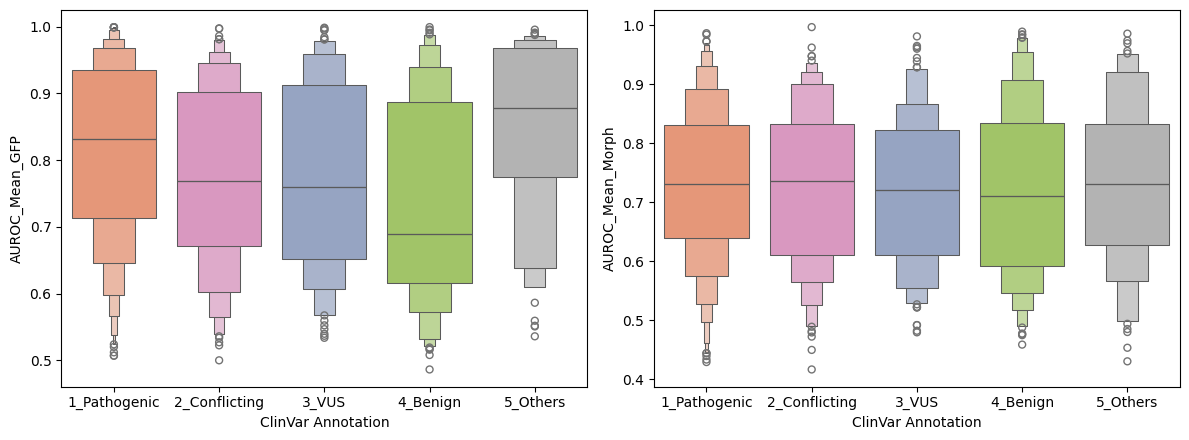

In [11]:
summary_clin_var = clin_var_annot_df.join(
    auroc_summary, 
    on=["gene_allele"]
).with_columns(
    pl.col("clinvar_clnsig_clean").replace(
        {
            "4_VUS": "3_VUS",
            "6_No_ClinVar": "5_Others",
            "2_Benign": "4_Benign",
            "3_Conflicting": "2_Conflicting"
        }).alias("clinvar_clnsig_clean"),
)

fig, axes = plt.subplots(1,2,figsize=(12, 4.5))
for i, change in enumerate(["GFP","Morph"]):
    # print(summary_clin_var.unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
    # Create the boxenplot
    plot_data = summary_clin_var.to_pandas()
    groups_order = sorted(summary_clin_var["clinvar_clnsig_clean"].drop_nulls().unique())
    if change != "GFP":
        chg_col = f"AUROC_Mean_{change}"
    else:
        chg_col = f"AUROC_Mean_{change}_Adj"
    sns.boxenplot(data=plot_data,
                  palette=palette_dict["clinvar_clnsig_clean"],  ##
                  x="clinvar_clnsig_clean", 
                  y=chg_col, 
                  hue="clinvar_clnsig_clean", saturation=.7,
                  order=groups_order,
                  hue_order=groups_order,
                  ax=axes[i]
                 )
    
    axes[i].set_ylabel(f"AUROC_Mean_{change}")
    # Add mean markers as triangles
    list_colors = list(palette_dict["clinvar_clnsig_clean"].values())
    # for j, group in enumerate(groups_order):
    #     group_data = plot_data[plot_data["clinvar_clnsig_clean"] == group]
    #     if not group_data.empty:
    #         group_mean = group_data[chg_col].mean()
    #         axes[i].scatter(j, group_mean, marker="^", s=120, 
    #                       color="tomato", #edgecolors="black", 
    #                       linewidth=1.5, zorder=10)
    
    # Add t-test comparison between "1_Pathogenic" and "3_Benign"
    if "1_Pathogenic" in groups_order and "4_Benign" in groups_order:
        from scipy.stats import ttest_ind
        pathogenic_data = plot_data[plot_data["clinvar_clnsig_clean"] == "1_Pathogenic"][chg_col].dropna()
        benign_data = plot_data[plot_data["clinvar_clnsig_clean"] == "4_Benign"][chg_col].dropna()
        # if len(pathogenic_data) > 0 and len(benign_data) > 0:
        #     t_stat, p_val = ttest_ind(pathogenic_data, benign_data)
            
        #     # Position the p-value text at the top of the plot
        #     y_max = ax[0].get_ylim()[1]
        #     y_pos = y_max * 0.95
            
        #     # Format p-value
        #     if p_val < 0.001:
        #         p_text = f"p < 0.001"
        #     else:
        #         p_text = f"p = {p_val:.3f}"
            
        #     ax[0].text(0.5, y_pos, f"t-test (Pathogenic vs Benign): {p_text}", 
        #               transform=ax[0].transData, ha="center", va="top",
        #               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        #               fontsize=10)
    
    # sns.swarmplot(data=summary_clin_var.to_pandas(), palette=palette_dict["clinvar_clnsig_clean"],
    #               x="clinvar_clnsig_clean_dbnsfp", y=f"AUROC_Mean_{change}", 
    #               ax=ax[0], order=sorted(clin_var_annot_df["clinvar_clnsig_clean"].drop_nulls().unique()))
    axes[i].set_xlabel("ClinVar Annotation")

plt.tight_layout()

<Axes: xlabel='AUROC_Mean_GFP_Adj', ylabel='rsa'>

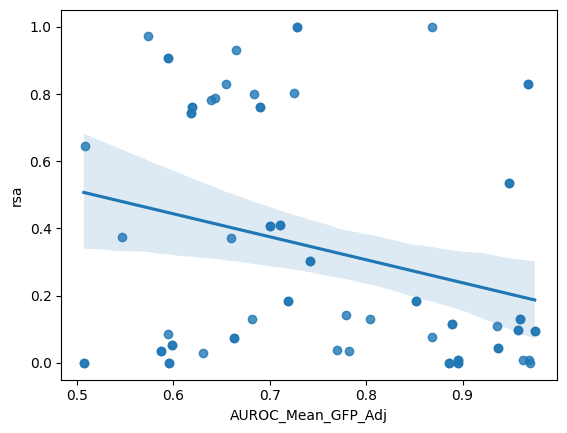

In [29]:
sns.regplot(
    data=summary_clin_var.filter(
        pl.col("symbol")=="F9"
    ).to_pandas(),
    x="AUROC_Mean_GFP_Adj",
    y="rsa"
)

<Axes: xlabel='RSA_Category', ylabel='AUROC_Mean_GFP_Adj'>

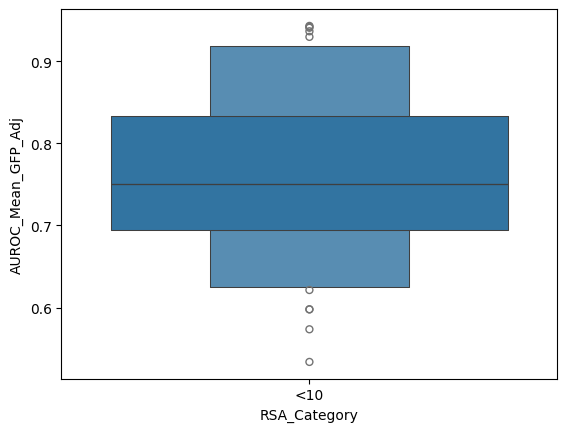

In [38]:
sns.boxenplot(
    data=summary_clin_var.filter(
        pl.col("symbol")=="DES"
    ).with_columns(
        pl.when(pl.col("rsa")<10)
        .then(pl.lit("<10"))
        .when(pl.col("rsa")>90)
        .then(pl.lit(">90"))
        .otherwise(pl.lit("10-90"))
        .alias("RSA_Category")
    ).to_pandas(),
    y="AUROC_Mean_GFP_Adj",
    x="RSA_Category"
)

In [32]:
[c for c in summary_clin_var.columns if "rsa" in c.lower()]

['rsa']

shape: (1, 4)
┌──────────────────────┬──────────────┬────────────┬────────────┐
│ clinvar_clnsig_clean ┆ total_counts ┆ hit_counts ┆ hit_perc   │
│ ---                  ┆ ---          ┆ ---        ┆ ---        │
│ str                  ┆ u32          ┆ u32        ┆ f64        │
╞══════════════════════╪══════════════╪════════════╪════════════╡
│ null                 ┆ 1083         ┆ 156        ┆ 107.978889 │
└──────────────────────┴──────────────┴────────────┴────────────┘

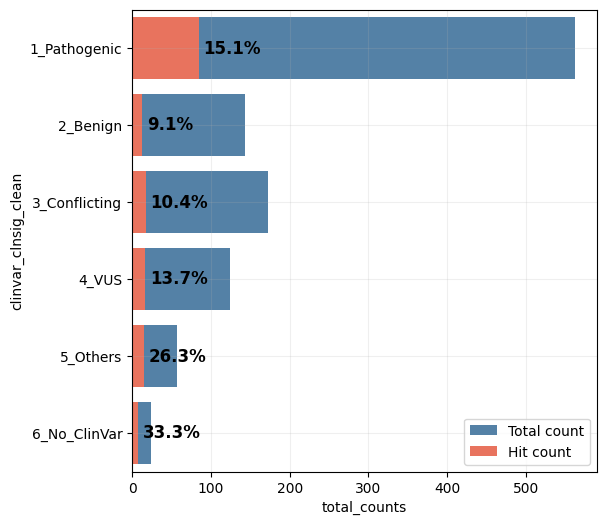

In [19]:
plot_assay_hit_by_category(
    summary_clin_var.with_columns(
        pl.when(pl.col("AUROC_Mean_GFP_Adj") > 0.95)
        .then(pl.lit(True))
        .otherwise(pl.lit(False))
        .alias("hit")
    ),
    hit_col="hit",
    cat_cols="clinvar_clnsig_clean"
).sum()

In [46]:
summary_clin_var.with_columns(
    pl.when(pl.col("AUROC_Mean_Morph") > 0.96)
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("hit")
).filter(
    pl.col("hit")    
).unique("gene_allele")

shape: (28, 561)
┌─────────┬──────────────┬────────┬──────────┬───┬──────────────┬─────────────┬─────────────┬──────┐
│ symbol  ┆ ensembl_gene ┆ orf_id ┆ mut_id   ┆ … ┆ AUROC_BioRep ┆ AUROC_BioRe ┆ AUROC_Mean_ ┆ hit  │
│ ---     ┆ _id          ┆ ---    ┆ ---      ┆   ┆ 2_DNA        ┆ p2_GFP      ┆ GFP_Adj     ┆ ---  │
│ str     ┆ ---          ┆ i64    ┆ f64      ┆   ┆ ---          ┆ ---         ┆ ---         ┆ bool │
│         ┆ str          ┆        ┆          ┆   ┆ f64          ┆ f64         ┆ f64         ┆      │
╞═════════╪══════════════╪════════╪══════════╪═══╪══════════════╪═════════════╪═════════════╪══════╡
│ MVK     ┆ ENSG00000110 ┆ 281    ┆ 200100.0 ┆ … ┆ 0.971937     ┆ 0.99843     ┆ null        ┆ true │
│         ┆ 921          ┆        ┆          ┆   ┆              ┆             ┆             ┆      │
│ BRCA1   ┆ null         ┆ 14613  ┆ null     ┆ … ┆ 0.888562     ┆ 0.922745    ┆ 0.913341    ┆ true │
│ BRCA1   ┆ null         ┆ 14613  ┆ null     ┆ … ┆ 0.94008      ┆ 0.937829    ┆ 0.922953    ┆ true │
│ MLH1    ┆ ENSG00000076 ┆ 2713   ┆ 4400.0   ┆ … ┆ 0.938085     ┆ 0.996421    ┆ null        ┆ true │
│         ┆ 242          ┆        ┆          ┆   ┆              ┆             ┆             ┆      │
│ BRCA1   ┆ null         ┆ 14613  ┆ null     ┆ … ┆ 0.959884     ┆ 0.97786     ┆ 0.979324    ┆ true │
│ …       ┆ …            ┆ …      ┆ …        ┆ … ┆ …            ┆ …           ┆ …           ┆ …    │
│ BRCA1   ┆ null         ┆ 14613  ┆ null     ┆ … ┆ 0.962855     ┆ 0.950067    ┆ 0.929054    ┆ true │
│ BRCA1   ┆ null         ┆ 14613  ┆ null     ┆ … ┆ 0.912732     ┆ 0.940617    ┆ 0.927901    ┆ true │
│ BRCA1   ┆ null         ┆ 14613  ┆ null     ┆ … ┆ 0.957383     ┆ 0.924586    ┆ 0.907193    ┆ true │
│ ZMYND10 ┆ ENSG00000004 ┆ 9866   ┆ 298.0    ┆ … ┆ null         ┆ null        ┆ 0.836786    ┆ true │
│         ┆ 838          ┆        ┆          ┆   ┆              ┆             ┆             ┆      │
│ BRCA1   ┆ null         ┆ 14613  ┆ null     ┆ … ┆ 0.900775     ┆ 0.891058    ┆ 0.901627    ┆ true │
└─────────┴──────────────┴────────┴──────────┴───┴──────────────┴─────────────┴─────────────┴──────┘

In [47]:
28 / 1083

0.02585410895660203

In [38]:
156 / 1083

0.1440443213296399

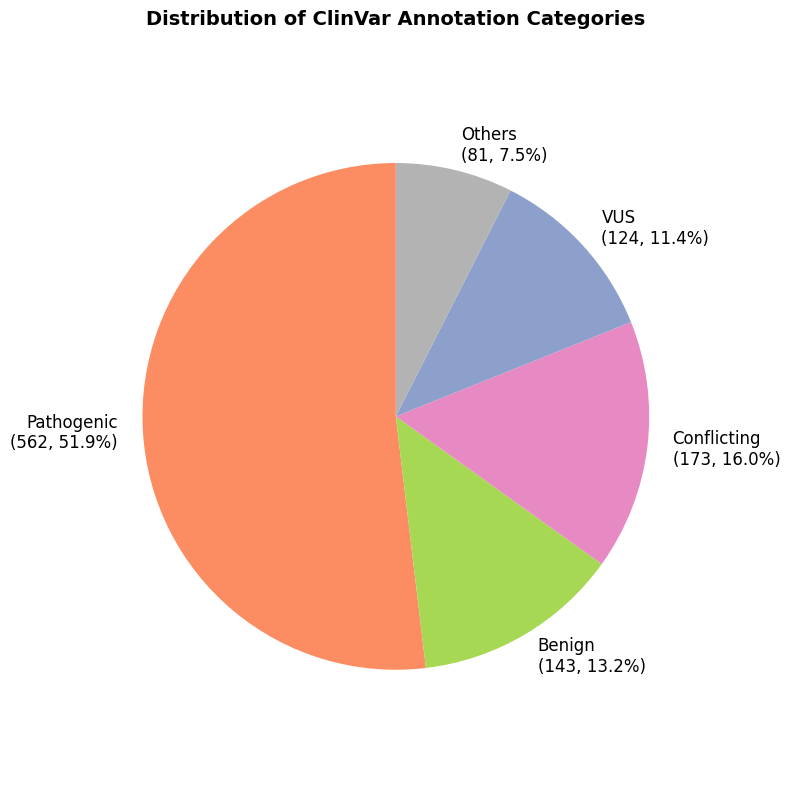

ClinVar Annotation Distribution:
1_Pathogenic: 562 variants (51.9%)
4_Benign: 143 variants (13.2%)
2_Conflicting: 173 variants (16.0%)
3_VUS: 124 variants (11.4%)
5_Others: 81 variants (7.5%)

Total variants: 1083


In [23]:
# Create pie chart for ClinVar annotation categories
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Get the category counts from the merged data
summary_clin_var_counts = summary_clin_var.group_by("clinvar_clnsig_clean").len() #.sort("clinvar_clnsig_clean")#.sort("len", descending=True)
summary_clin_var_counts = summary_clin_var.group_by("clinvar_clnsig_clean").len().to_pandas()
category_order = ["1_Pathogenic", "4_Benign", "2_Conflicting", "3_VUS", "5_Others"]
summary_clin_var_counts['clinvar_clnsig_clean'] = pd.Categorical(summary_clin_var_counts['clinvar_clnsig_clean'], categories=category_order, ordered=True)

# Convert to pandas for easier plotting
pie_data = summary_clin_var_counts.sort_values('clinvar_clnsig_clean')
pie_data = pie_data.dropna()  # Remove any null values

# Calculate percentages
total_count = pie_data["len"].sum()
pie_data["percentage"] = (pie_data["len"] / total_count * 100).round(1)

# Create labels with counts and percentages
labels = [f"{cat.split('_')[1]}\n({count}, {pct}%)" 
          for cat, count, pct in zip(pie_data["clinvar_clnsig_clean"], 
                                   pie_data["len"], 
                                   pie_data["percentage"])]

# Use a color palette that matches the boxenplot
colors = list(palette_dict["clinvar_clnsig_clean"].values())
# colors[1], colors[3] = colors[3], colors[1]  # Swap colors to match the order in pie chart
# Create pie chart
wedges, texts, autotexts = ax.pie(pie_data["len"], 
                                  labels=labels, 
                                  colors=colors,
                                  autopct="",  # We're including percentages in labels
                                  startangle=90,
                                  textprops={'fontsize': 12})

ax.set_title("Distribution of ClinVar Annotation Categories", fontsize=14, fontweight='bold', pad=20)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# # Add a legend
# ax.legend(wedges, [f"{cat} (n={count})" for cat, count in zip(pie_data["clinvar_clnsig_clean"], pie_data["len"])],
#           title="Categories",
#           loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Print summary statistics
print("ClinVar Annotation Distribution:")
print("=" * 40)
for _, row in pie_data.iterrows():
    print(f"{row['clinvar_clnsig_clean']}: {row['len']} variants ({row['percentage']}%)")
print(f"\nTotal variants: {total_count}")

<Axes: xlabel='AUROC_Mean_GFP', ylabel='AUROC_Mean_GFP_Adj'>

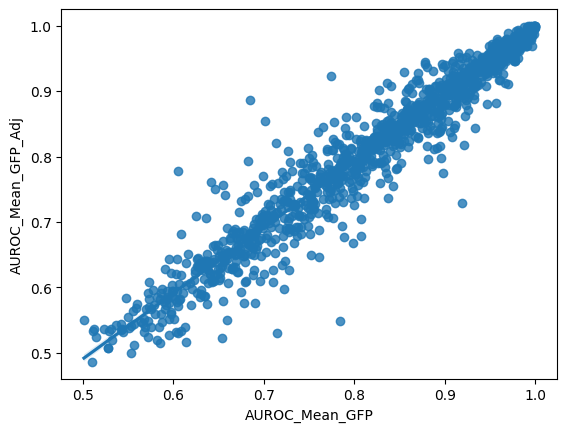

In [ ]:
auroc_adj_gfp_df = pl.read_csv("../outputs/2.classification_results/imaging_analyses_classification_summary_all_gfp_adj_auroc.csv")
auroc_summary = pl.read_csv("../outputs/2.classification_results/imaging_analyses_classification_summary_all.csv")

auroc_summary = auroc_summary.join(
    auroc_adj_gfp_df,
    left_on="gene_allele",
    right_on="allele_0",
    how="left"
)
sns.regplot(
    data=auroc_summary.to_pandas(),
    x="AUROC_Mean_GFP",
    y="AUROC_Mean_GFP_Adj"
)